In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
import itertools
import glob, os
import statsmodels.api as sm
from numpy.polynomial.polynomial import polyfit

warnings.filterwarnings('ignore')

Loading the GDP file

In [2]:
gdp_df = pd.read_csv('./datasets/GDP.csv')
gdp_df.shape

(11, 36)

Checking the data type and column name

In [3]:
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Items  Description         11 non-null     object 
 1   Duration                   11 non-null     object 
 2   Andhra Pradesh             11 non-null     float64
 3   Arunachal Pradesh          9 non-null      float64
 4   Assam                      9 non-null      float64
 5   Bihar                      9 non-null      float64
 6   Chhattisgarh               11 non-null     float64
 7   Goa                        9 non-null      float64
 8   Gujarat                    9 non-null      float64
 9   Haryana                    11 non-null     float64
 10  Himachal Pradesh           7 non-null      float64
 11  Jammu & Kashmir            9 non-null      float64
 12  Jharkhand                  9 non-null      float64
 13  Karnataka                  9 non-null      float64
 

# Observation from the info:
- There are two categorical columns - Items description and duration
- There are some null rows in the above columns

In [4]:
gdp_df.columns = gdp_df.columns.str.strip()
list(gdp_df.columns)

['Items  Description',
 'Duration',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bihar',
 'Chhattisgarh',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jammu & Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'Odisha',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'West Bengal1',
 'Andaman & Nicobar Islands',
 'Chandigarh',
 'Delhi',
 'Puducherry',
 'All_India GDP']

In [5]:
union_territories = ["Andaman & Nicobar Islands", "Chandigarh", "Delhi", "Puducherry"]
gdp_df.drop(union_territories, axis = 1, inplace = True) 
gdp_df.head()

,Items Description,Duration,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chhattisgarh,Goa,Gujarat,Haryana,...,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand,West Bengal1,All_India GDP
0,GSDP - CURRENT PRICES (` in Crore),2011-12,379402.0,11063.0,143175.0,247144.0,158074.0,42367.0,615606.0,297539.0,...,266628.0,436465.0,11165.0,751485.0,359433.0,19208.0,724049.0,115523.0,NaN,8736039.0
1,GSDP - CURRENT PRICES (` in Crore),2012-13,411404.0,12547.0,156864.0,282368.0,177511.0,38120.0,724495.0,347032.0,...,297734.0,494004.0,12338.0,855481.0,401493.0,21663.0,822903.0,131835.0,NaN,9946636.0
2,GSDP - CURRENT PRICES (` in Crore),2013-14,464272.0,14602.0,177745.0,317101.0,206690.0,35921.0,807623.0,400662.0,...,334714.0,549701.0,13862.0,971090.0,452186.0,25593.0,944146.0,149817.0,NaN,11236635.0
3,GSDP - CURRENT PRICES (` in Crore),2014-15,526468.0,16761.0,198098.0,373920.0,234982.0,40633.0,895027.0,437462.0,...,368011.0,612194.0,15209.0,1092564.0,511178.0,29667.0,1043371.0,161985.0,NaN,12433749.0
4,GSDP - CURRENT PRICES (` in Crore),2015-16,609934.0,18784.0,224234.0,413503.0,260776.0,45002.0,994316.0,485184.0,...,NaN,NaN,16637.0,1212668.0,575631.0,NaN,1153795.0,184091.0,NaN,13675331.0


In [6]:
gdp_df.drop(["West Bengal1"], axis = 1, inplace = True) 
gdp_df.head()

,Items Description,Duration,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chhattisgarh,Goa,Gujarat,Haryana,...,Odisha,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand,All_India GDP
0,GSDP - CURRENT PRICES (` in Crore),2011-12,379402.0,11063.0,143175.0,247144.0,158074.0,42367.0,615606.0,297539.0,...,227872.0,266628.0,436465.0,11165.0,751485.0,359433.0,19208.0,724049.0,115523.0,8736039.0
1,GSDP - CURRENT PRICES (` in Crore),2012-13,411404.0,12547.0,156864.0,282368.0,177511.0,38120.0,724495.0,347032.0,...,258275.0,297734.0,494004.0,12338.0,855481.0,401493.0,21663.0,822903.0,131835.0,9946636.0
2,GSDP - CURRENT PRICES (` in Crore),2013-14,464272.0,14602.0,177745.0,317101.0,206690.0,35921.0,807623.0,400662.0,...,291709.0,334714.0,549701.0,13862.0,971090.0,452186.0,25593.0,944146.0,149817.0,11236635.0
3,GSDP - CURRENT PRICES (` in Crore),2014-15,526468.0,16761.0,198098.0,373920.0,234982.0,40633.0,895027.0,437462.0,...,321971.0,368011.0,612194.0,15209.0,1092564.0,511178.0,29667.0,1043371.0,161985.0,12433749.0
4,GSDP - CURRENT PRICES (` in Crore),2015-16,609934.0,18784.0,224234.0,413503.0,260776.0,45002.0,994316.0,485184.0,...,341887.0,NaN,NaN,16637.0,1212668.0,575631.0,NaN,1153795.0,184091.0,13675331.0


In [7]:
print("Number of columns and rows after dropping the unneccessary columns:\nColumns:{0} \nRows:{1}".format(gdp_df.shape[1], gdp_df.shape[0]))

Number of columns and rows after dropping the unneccessary columns:
Columns:31 
Rows:11


In [8]:
pd.DataFrame([[gdp_df.shape],
            [gdp_df.isnull().sum().sum()],
             [gdp_df.duplicated().sum()]],
            columns = ['GDP data set'],
            index = ['Shape', 'Missingness', 'Duplicates'])

,GDP data set
Shape,"(11, 31)"
Missingness,56
Duplicates,0


In [9]:
gdp_df[gdp_df.columns[gdp_df.isnull().any()]].isnull().sum()

Arunachal Pradesh    2
Assam                2
Bihar                2
Goa                  2
Gujarat              2
Himachal Pradesh     4
Jammu & Kashmir      2
Jharkhand            2
Karnataka            2
Kerala               2
Maharashtra          4
Manipur              4
Mizoram              4
Nagaland             4
Punjab               4
Rajasthan            4
Sikkim               2
Tripura              4
Uttar Pradesh        2
Uttarakhand          2
dtype: int64

In [10]:
gdp_df[gdp_df.columns[gdp_df.isnull().any()]].isnull().sum().sum()

56

In [11]:
duration_list=['2011-12','2012-13','2013-14','2014-15','2015-16','2016-17']
for duration in duration_list:
    missing_val = gdp_df[gdp_df['Duration']==duration].isnull().sum().sum()
    print('Total missing values for duration {0}: {1}'.format(duration,missing_val))

Total missing values for duration 2011-12: 0
Total missing values for duration 2012-13: 0
Total missing values for duration 2013-14: 0
Total missing values for duration 2014-15: 0
Total missing values for duration 2015-16: 16
Total missing values for duration 2016-17: 40


In [12]:
gsdp_df = gdp_df[gdp_df['Items  Description'].str.contains('GSDP')]
gsdp_df.drop(columns=['Items  Description'],inplace=True)
gsdp_df

,Duration,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chhattisgarh,Goa,Gujarat,Haryana,Himachal Pradesh,...,Odisha,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand,All_India GDP
0,2011-12,379402.0,11063.0,143175.0,247144.0,158074.0,42367.0,615606.0,297539.0,72720.0,...,227872.0,266628.0,436465.0,11165.0,751485.0,359433.0,19208.0,724049.0,115523.0,8736039.0
1,2012-13,411404.0,12547.0,156864.0,282368.0,177511.0,38120.0,724495.0,347032.0,82820.0,...,258275.0,297734.0,494004.0,12338.0,855481.0,401493.0,21663.0,822903.0,131835.0,9946636.0
2,2013-14,464272.0,14602.0,177745.0,317101.0,206690.0,35921.0,807623.0,400662.0,94764.0,...,291709.0,334714.0,549701.0,13862.0,971090.0,452186.0,25593.0,944146.0,149817.0,11236635.0
3,2014-15,526468.0,16761.0,198098.0,373920.0,234982.0,40633.0,895027.0,437462.0,104369.0,...,321971.0,368011.0,612194.0,15209.0,1092564.0,511178.0,29667.0,1043371.0,161985.0,12433749.0
4,2015-16,609934.0,18784.0,224234.0,413503.0,260776.0,45002.0,994316.0,485184.0,NaN,...,341887.0,NaN,NaN,16637.0,1212668.0,575631.0,NaN,1153795.0,184091.0,13675331.0
5,2016-17,699307.0,NaN,NaN,NaN,290140.0,NaN,NaN,547396.0,NaN,...,378991.0,NaN,NaN,NaN,1338766.0,654294.0,NaN,NaN,NaN,15251028.0


In [13]:

growth_df = gdp_df[gdp_df['Items  Description'].str.contains('Growth')]
growth_df.drop(columns=['Items  Description'],inplace=True)
growth_df

,Duration,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chhattisgarh,Goa,Gujarat,Haryana,Himachal Pradesh,...,Odisha,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand,All_India GDP
6,2012-13,8.43,13.41,9.56,14.25,12.30,-10.02,17.69,16.63,13.89,...,13.34,11.67,13.18,10.51,13.84,11.70,12.78,13.65,14.12,13.86
7,2013-14,12.85,16.38,13.31,12.30,16.44,-5.77,11.47,15.45,14.42,...,12.95,12.42,11.27,12.35,13.51,12.63,18.14,14.73,13.64,12.97
8,2014-15,13.40,14.79,11.45,17.92,13.69,13.12,10.82,9.18,10.14,...,10.37,9.95,11.37,9.72,12.51,13.05,15.92,10.51,8.12,10.65
9,2015-16,15.85,12.07,13.19,10.59,10.98,10.75,11.09,10.91,NaN,...,6.19,NaN,NaN,9.39,10.99,12.61,NaN,10.58,13.65,9.99
10,2016-17,14.65,NaN,NaN,NaN,11.26,NaN,NaN,12.82,NaN,...,10.85,NaN,NaN,NaN,10.40,13.67,NaN,NaN,NaN,11.52


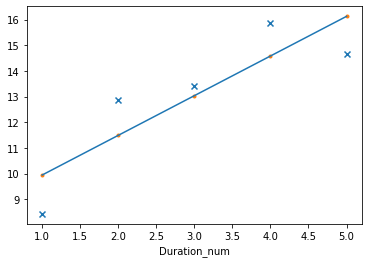

In [14]:
growth_cc_df = growth_df.copy()
growth_cc_df['Duration_num'] = growth_cc_df.Duration.map({'2012-13':1,'2013-14':2,'2014-15':3,
                                                          '2015-16':4,'2016-17':5})
x=growth_cc_df['Duration_num']
y=growth_cc_df['Andhra Pradesh']
# y.dropna(inplace=True)
z = np.polyfit(x,y,deg=1) 
p = np.poly1d(z)
plt.scatter(x,y, marker='x')
plt.scatter(x, p(x), marker='.')
sns.lineplot(x,p(x))
plt.show()

In [15]:
#Plots seaborn barlot
plt.style.use('seaborn-white')
def subplot_barplot(dataframe, list_of_x, target):
    sns.set(font_scale=1)
    nrows = int(np.ceil(len(list_of_x)/2)) # Makes sure you have enough rows
    #tweak figsize scaler if graphs don't fit well
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15, len(list_of_x)*3), sharex=False, sharey=False)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    for i, x_axis in enumerate(list_of_x): # Gives us an index value to get into all our lists
        sns.barplot(x = dataframe[x_axis], y = dataframe[target], data = dataframe, ax=ax[i])
        ax[i].set_title('% Growth over previous year for State {0}'.format(list_of_x[i]))
        ax[i].set_xlabel('Percentage') 
        ax[i].set_ylabel(target)
        

#Plots seaborn linelot
plt.style.use('seaborn-white')
def subplot_lineplot(dataframe, nation_df,list_of_x, target):
    sns.set(font_scale=1)
    nrows = int(np.ceil(len(list_of_x)/2)) # Makes sure you have enough rows
    #tweak figsize scaler if graphs don't fit well
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15, len(list_of_x)*3), sharex=False, sharey=False)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    dataframe['Duration_num'] = dataframe[target].map({'2012-13':1,
                                                          '2013-14':2,'2014-15':3,'2015-16':4,'2016-17':5})
    nation_df['Duration_num'] = nation_df[target].map({'2012-13':1,
                                                          '2013-14':2,'2014-15':3,'2015-16':4,'2016-17':5})
    
    df_slope = pd.DataFrame(columns=['State','Slope'])
    for i, x_axis in enumerate(list_of_x): # Gives us an index value to get into all our lists

        # sns.lineplot(x = target, y = x_axis, data = dataframe, ax=ax[i],label='{0} Growth%'.format(list_of_x[i]),markers='+')
        # sns.lineplot(x = 'Duration', y = 'All_India GDP', data = nation_df, ax=ax[i],label='All India Growth%',markers='o')
        

        
        x=dataframe['Duration_num']
        y=dataframe[x_axis]#.fillna(0)
        idx = np.isfinite(x) & np.isfinite(y)## this will take care of null values
        m,c = np.polyfit(x[idx], y[idx], 1)
        
        row = [list_of_x[i],m]
        df_slope.loc[i] = row
        
        
        sns.scatterplot(x='Duration_num',y=x_axis,data = dataframe, markers='x',ax=ax[i],
                        label='{0} Growth%'.format(list_of_x[i]))
        sns.lineplot(x,m*x+c,ax=ax[i],label='{0} Growth%'.format(list_of_x[i]),markers='o')
        
        x_nation=nation_df['Duration_num']
        y_nation=nation_df['All_India GDP'].fillna(0)
        m_nation,c_nation = np.polyfit(x_nation,y_nation,deg=1) 
        sns.scatterplot(x='Duration_num',y='All_India GDP',data = nation_df, markers='x',ax=ax[i],
                        label='All India Growth%')
        sns.lineplot(x_nation,m_nation*x_nation+c_nation,ax=ax[i],
                     label='All India Growth%',markers='o')
        
        ax[i].set_title('% Growth over previous year for State {0}'.format(list_of_x[i]),color='blue')
        ax[i].set_ylabel('Percentage') 
        ax[i].set_xlabel(target)
        ax[i].set_xticklabels(size=10, labels=[' ','2012-13',' ','2013-14',' ','2014-15',' ','2015-16',' ',
                                               '2016-17'])
        
    return df_slope

In [16]:
col_list=[col for col in growth_df if col!='All_India GDP']
col_sel_list = [col for col in col_list if col!='Duration']
growth_sel_df = growth_df[col_list]

In [17]:
growth_sel_df

,Duration,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chhattisgarh,Goa,Gujarat,Haryana,Himachal Pradesh,...,Nagaland,Odisha,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand
6,2012-13,8.43,13.41,9.56,14.25,12.30,-10.02,17.69,16.63,13.89,...,15.03,13.34,11.67,13.18,10.51,13.84,11.70,12.78,13.65,14.12
7,2013-14,12.85,16.38,13.31,12.30,16.44,-5.77,11.47,15.45,14.42,...,21.98,12.95,12.42,11.27,12.35,13.51,12.63,18.14,14.73,13.64
8,2014-15,13.40,14.79,11.45,17.92,13.69,13.12,10.82,9.18,10.14,...,10.85,10.37,9.95,11.37,9.72,12.51,13.05,15.92,10.51,8.12
9,2015-16,15.85,12.07,13.19,10.59,10.98,10.75,11.09,10.91,NaN,...,NaN,6.19,NaN,NaN,9.39,10.99,12.61,NaN,10.58,13.65
10,2016-17,14.65,NaN,NaN,NaN,11.26,NaN,NaN,12.82,NaN,...,NaN,10.85,NaN,NaN,NaN,10.40,13.67,NaN,NaN,NaN


In [18]:
nation_growth_df=growth_df[['Duration','All_India GDP']]
nation_growth_df

,Duration,All_India GDP
6,2012-13,13.86
7,2013-14,12.97
8,2014-15,10.65
9,2015-16,9.99
10,2016-17,11.52


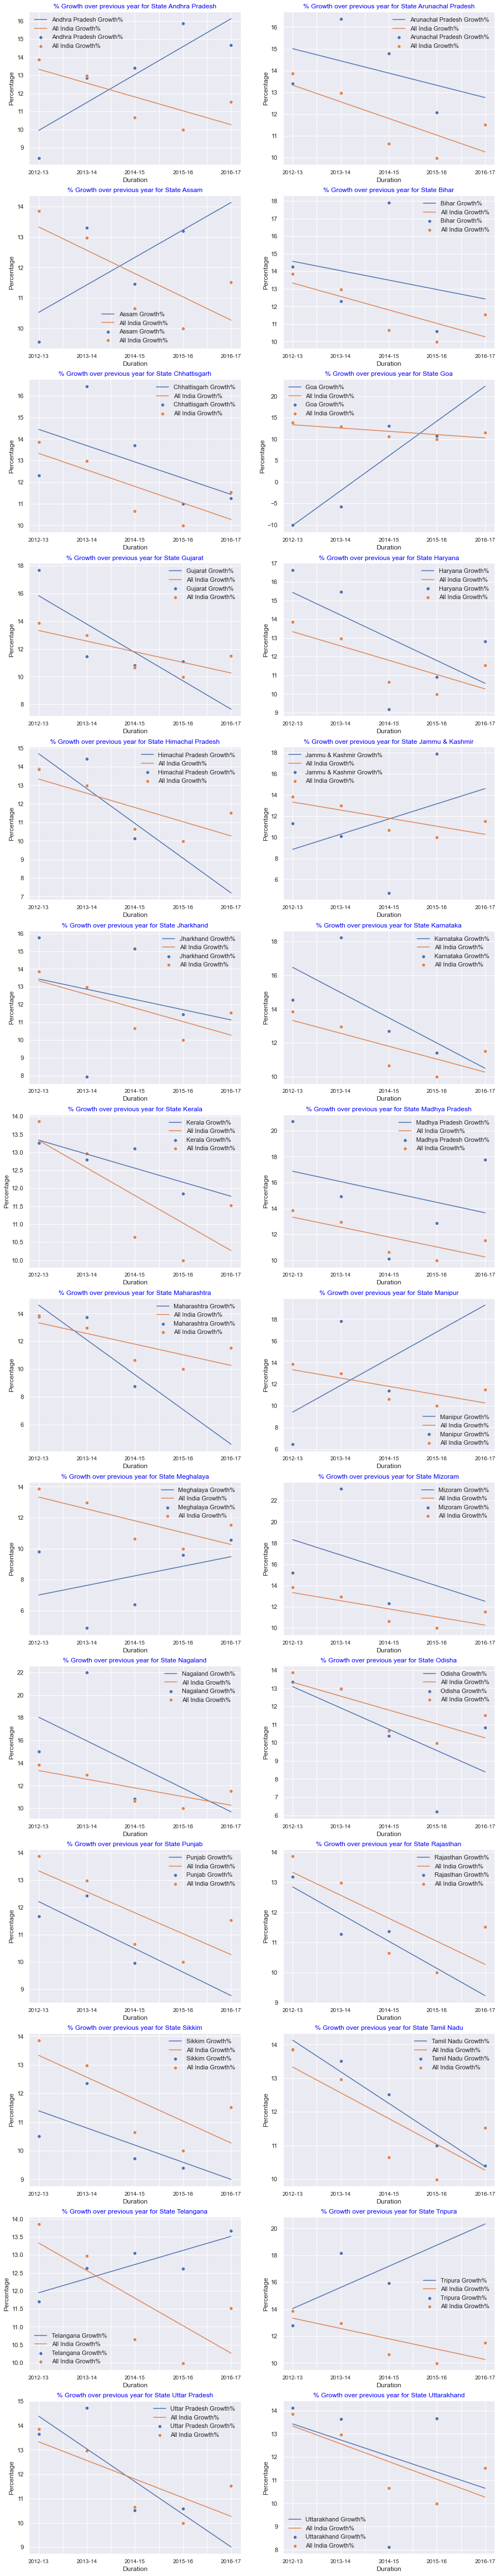

In [19]:
slop_df = subplot_lineplot(growth_sel_df,nation_growth_df, col_sel_list, 'Duration')

In [20]:
slop_df.sort_values(by='Slope',ascending=False)

,State,Slope
5,Goa,8.120
15,Manipur,2.470
25,Tripura,1.570
0,Andhra Pradesh,1.544
9,Jammu & Kashmir,1.441
2,Assam,0.903
16,Meghalaya,0.619
24,Telangana,0.392
12,Kerala,-0.391
3,Bihar,-0.536


In [21]:
growth_transpose_df= growth_df.T
growth_transpose_df.rename(columns={6:'2012-13',
                                    7:'2013-14',8:'2014-15',9:'2015-16',10:'2016-17'},inplace=True)
growth_transpose_df = growth_transpose_df[1:]
growth_transpose_df

,2012-13,2013-14,2014-15,2015-16,2016-17
Andhra Pradesh,8.43,12.85,13.4,15.85,14.65
Arunachal Pradesh,13.41,16.38,14.79,12.07,NaN
Assam,9.56,13.31,11.45,13.19,NaN
Bihar,14.25,12.3,17.92,10.59,NaN
Chhattisgarh,12.3,16.44,13.69,10.98,11.26
Goa,-10.02,-5.77,13.12,10.75,NaN
Gujarat,17.69,11.47,10.82,11.09,NaN
Haryana,16.63,15.45,9.18,10.91,12.82
Himachal Pradesh,13.89,14.42,10.14,NaN,NaN
Jammu & Kashmir,11.31,10.09,4.7,17.91,NaN


In [22]:
growth_transpose_df['Average_Growth'] = round(growth_transpose_df.mean(axis=1),2)
growth_transpose_df.sort_values(by='Average_Growth',ascending=False)

,2012-13,2013-14,2014-15,2015-16,2016-17,Average_Growth
Mizoram,15.2,23.1,12.3,NaN,NaN,16.87
Nagaland,15.03,21.98,10.85,NaN,NaN,15.95
Tripura,12.78,18.14,15.92,NaN,NaN,15.61
Madhya Pradesh,20.71,14.91,10.11,12.86,17.74,15.27
Karnataka,14.56,18.24,12.7,11.42,NaN,14.23
Arunachal Pradesh,13.41,16.38,14.79,12.07,NaN,14.16
Bihar,14.25,12.3,17.92,10.59,NaN,13.76
Andhra Pradesh,8.43,12.85,13.4,15.85,14.65,13.04
Haryana,16.63,15.45,9.18,10.91,12.82,13.00
Chhattisgarh,12.3,16.44,13.69,10.98,11.26,12.93


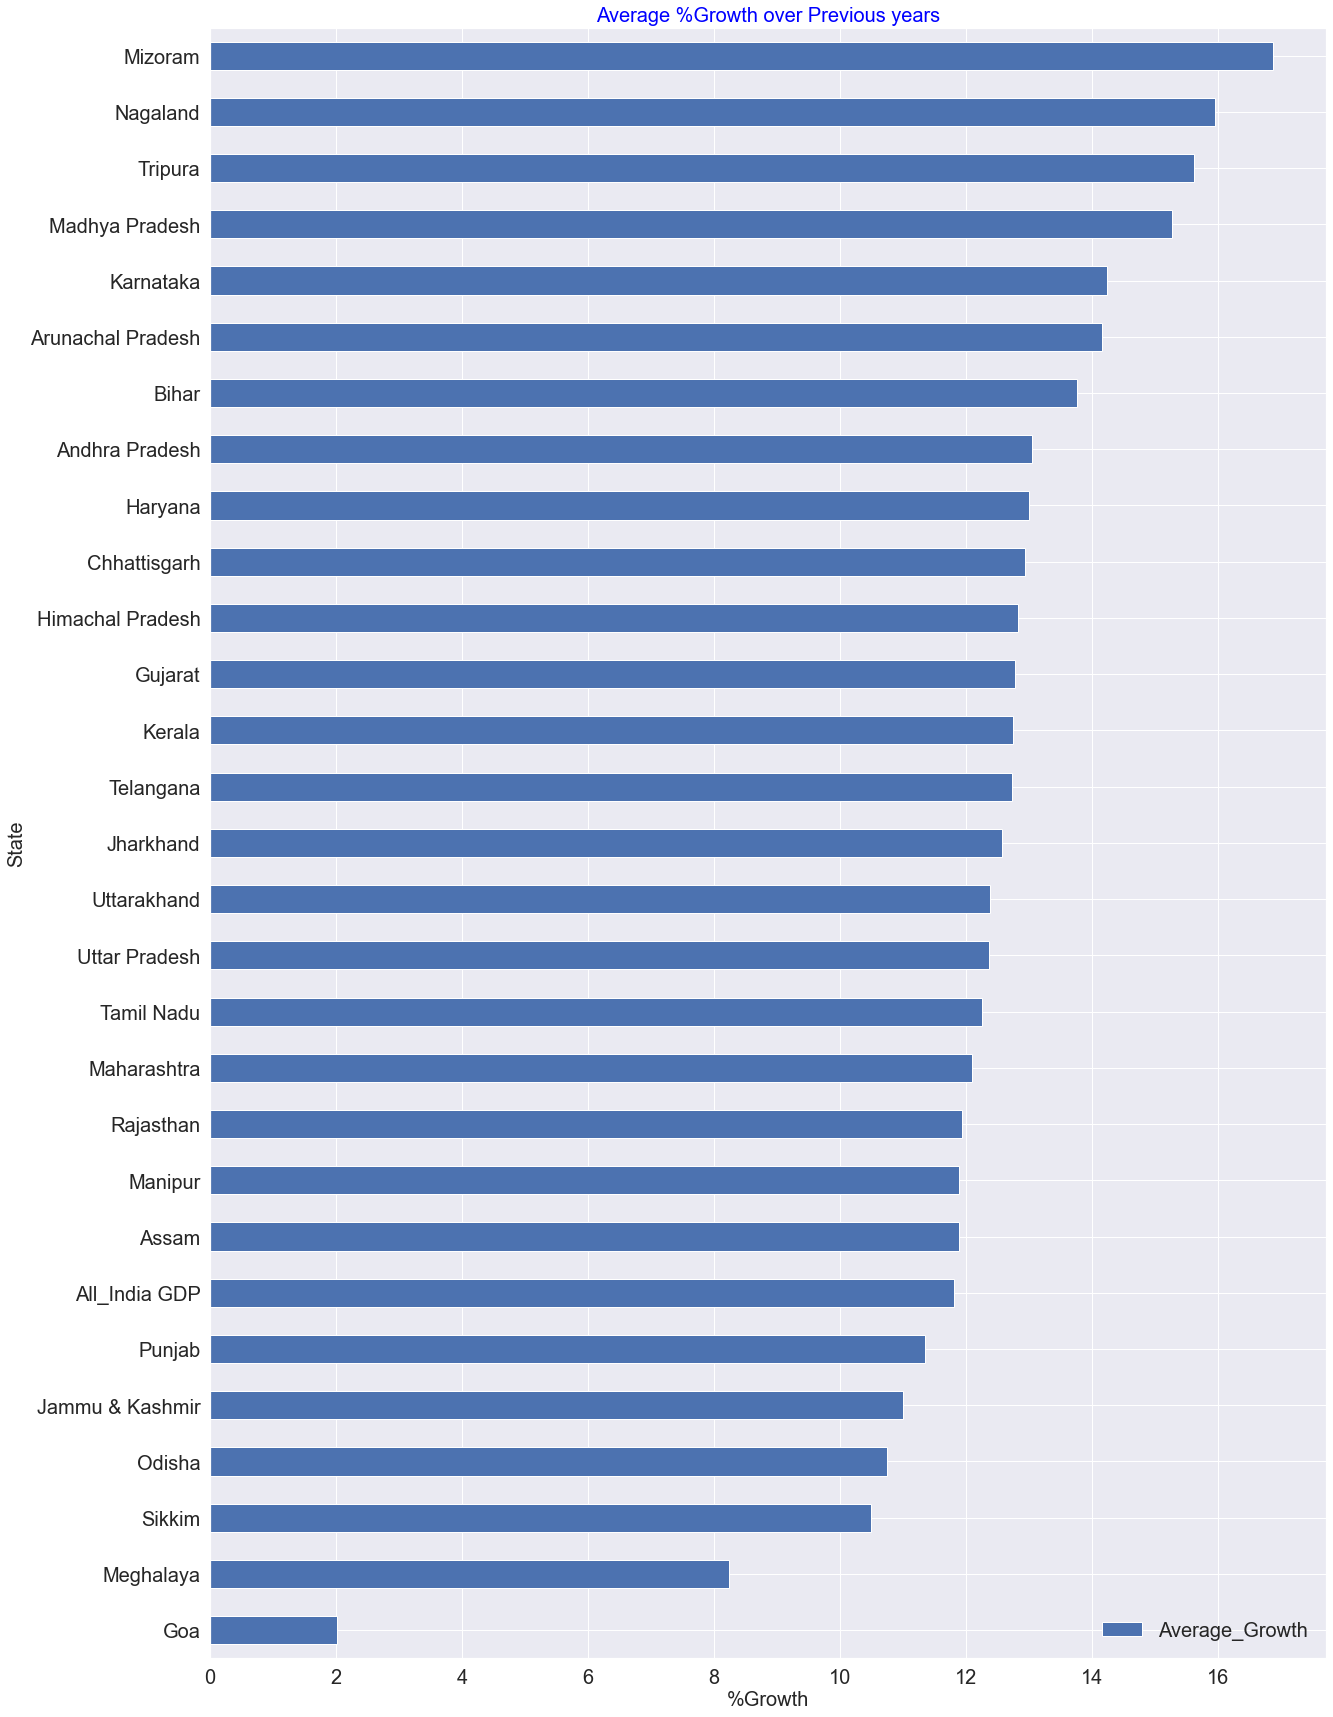

In [23]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
growth_transpose_df['Average_Growth'].sort_values(ascending=True).plot(kind='barh',
          figsize=(20,30));
plt.title('Average %Growth over Previous years',color='blue')
plt.ylabel('State')
plt.xlabel('%Growth');
plt.legend();
# plt.savefig('./images/StateAverageGrowth.png')

In [24]:
gsdp_copy_df=gsdp_df.copy()
gsdp_copy_df=gsdp_copy_df[gsdp_copy_df['Duration']=='2015-16']
gsdp_copy_df

,Duration,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chhattisgarh,Goa,Gujarat,Haryana,Himachal Pradesh,...,Odisha,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand,All_India GDP
4,2015-16,609934.0,18784.0,224234.0,413503.0,260776.0,45002.0,994316.0,485184.0,NaN,...,341887.0,NaN,NaN,16637.0,1212668.0,575631.0,NaN,1153795.0,184091.0,13675331.0


In [25]:
gsdp_transpose_df = gsdp_copy_df.T
gsdp_transpose_df.rename(columns={4:'2015-16'},inplace=True)
gsdp_transpose_df = gsdp_transpose_df[1:].sort_values(by='2015-16',ascending=False)
gsdp_transpose_df

,2015-16
All_India GDP,1.36753e+07
Tamil Nadu,1.21267e+06
Uttar Pradesh,1.1538e+06
Karnataka,1.02707e+06
Gujarat,994316
Andhra Pradesh,609934
Kerala,588337
Telangana,575631
Madhya Pradesh,543975
Haryana,485184


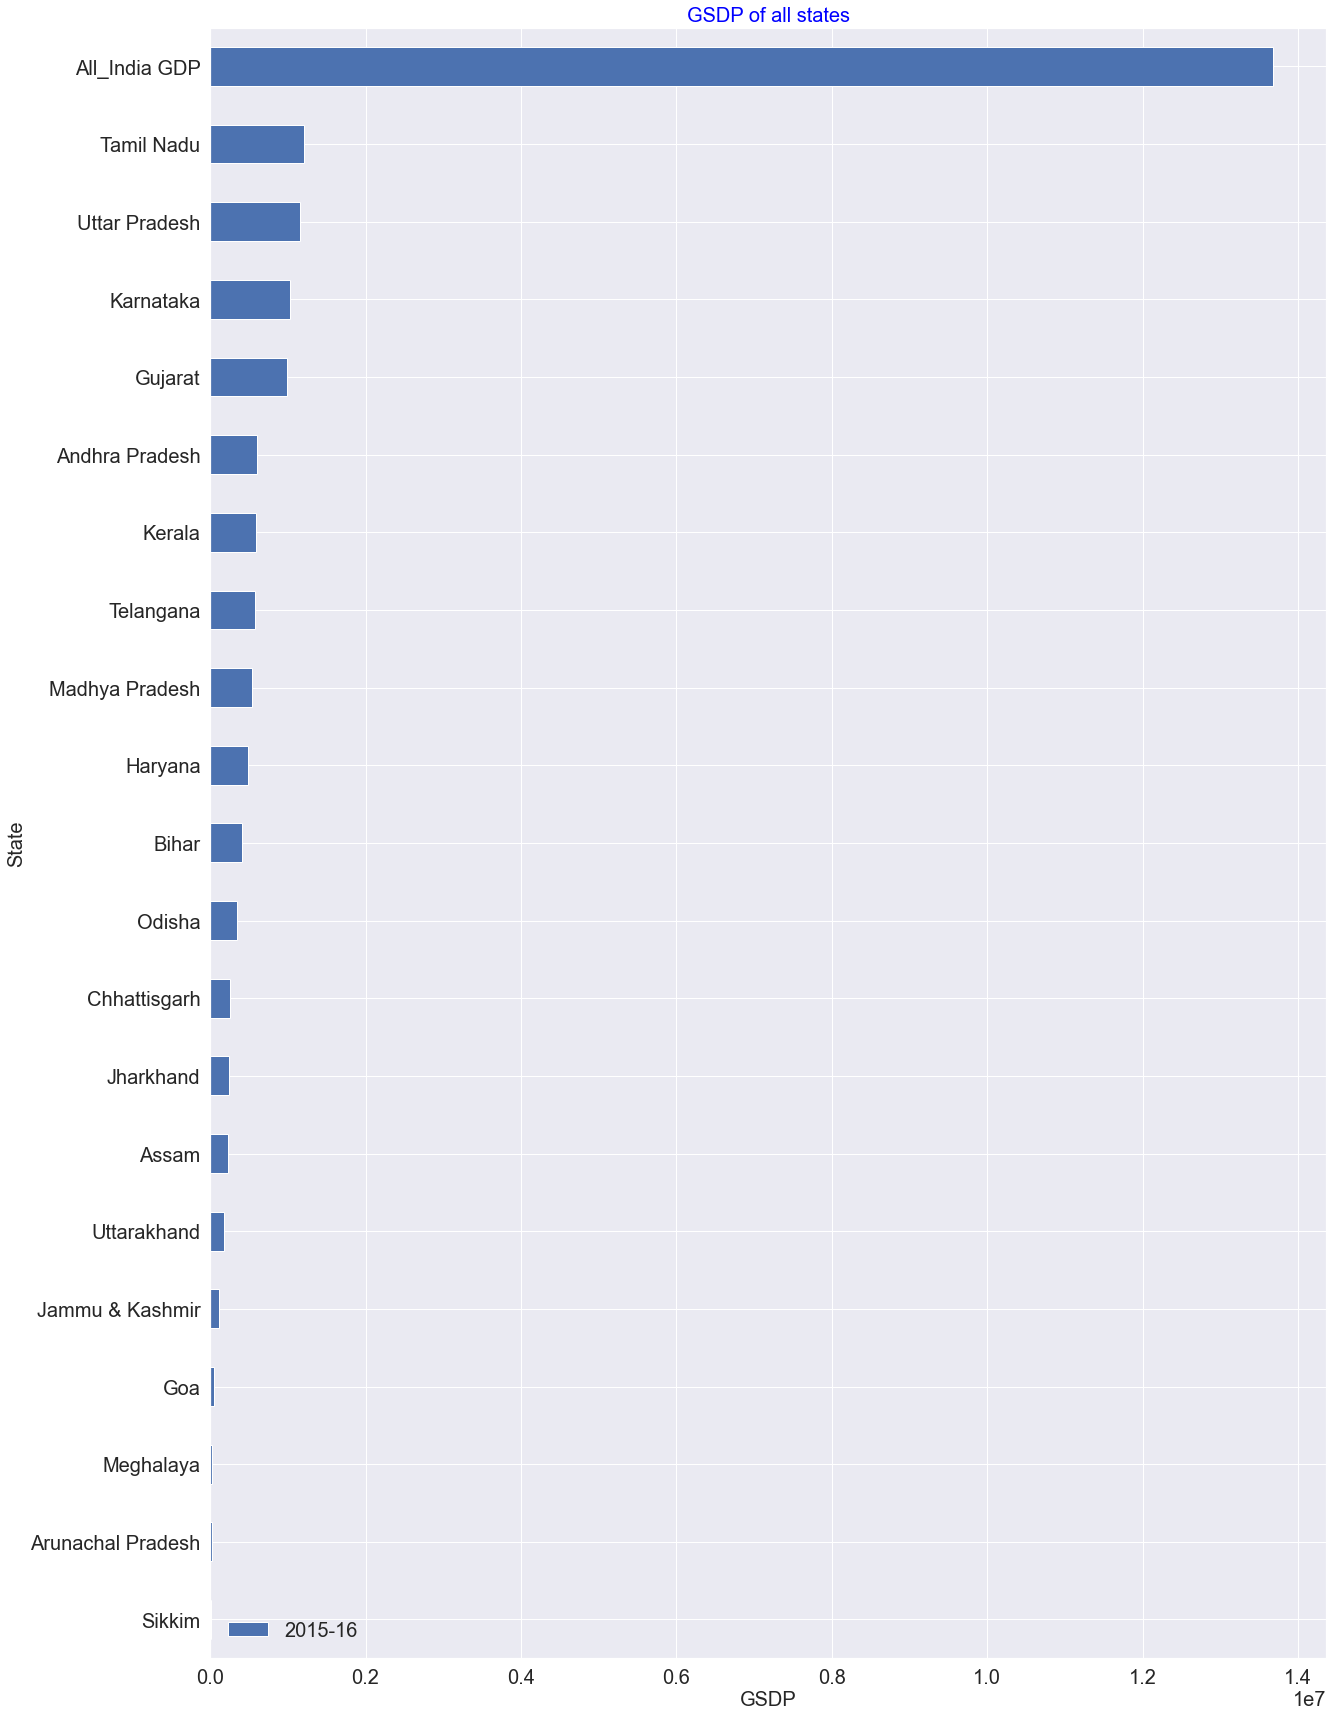

In [26]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
gsdp_transpose_df.dropna().sort_values(by='2015-16',ascending=True).plot(kind='barh',
          figsize=(20,30));
plt.title('GSDP of all states',color='blue')
plt.ylabel('State')
plt.xlabel('GSDP');

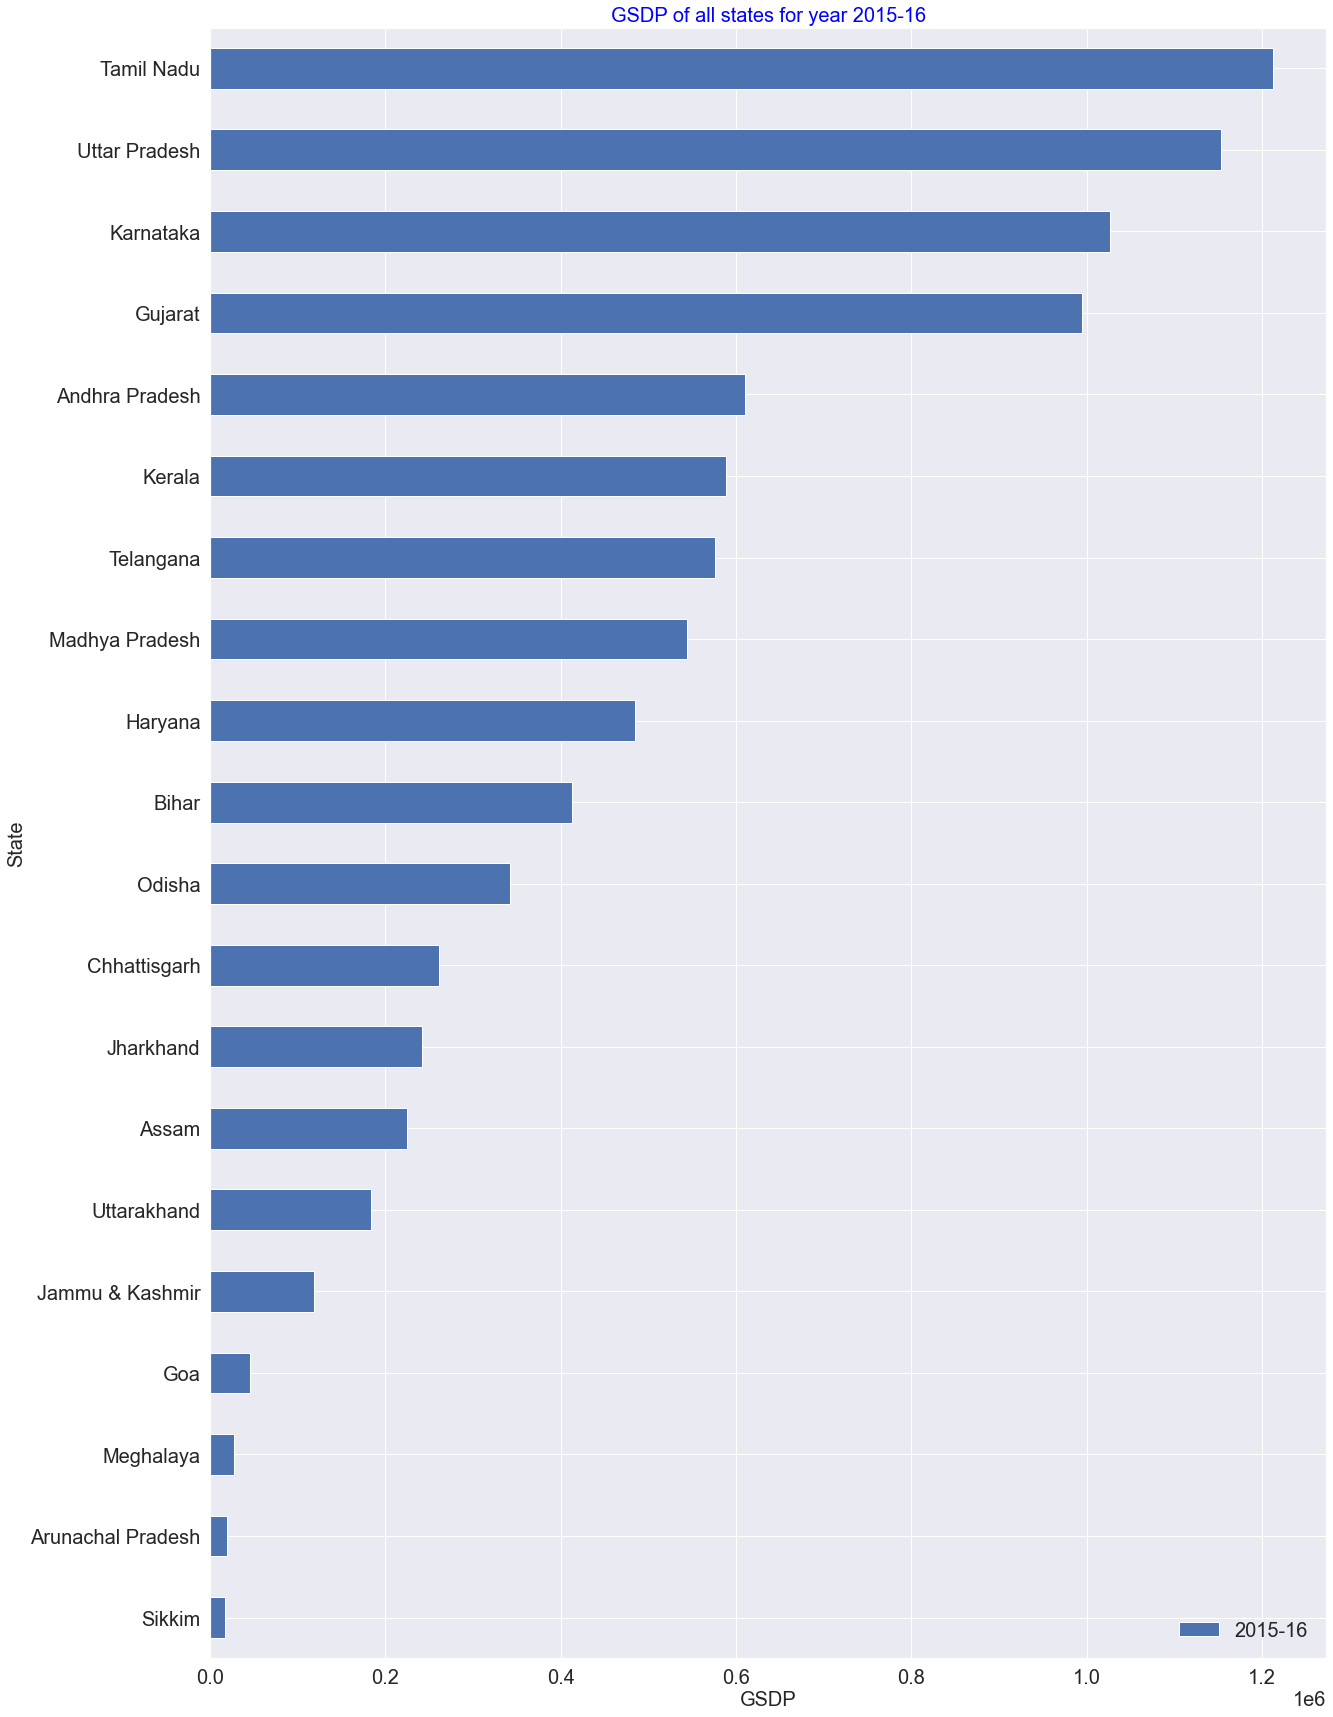

In [27]:
MALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
gsdp_transpose_df[1:].dropna().sort_values(by='2015-16',ascending=True).plot(kind='barh',
          figsize=(20,30));
plt.title('GSDP of all states for year 2015-16',color='blue')
plt.ylabel('State')
plt.xlabel('GSDP');


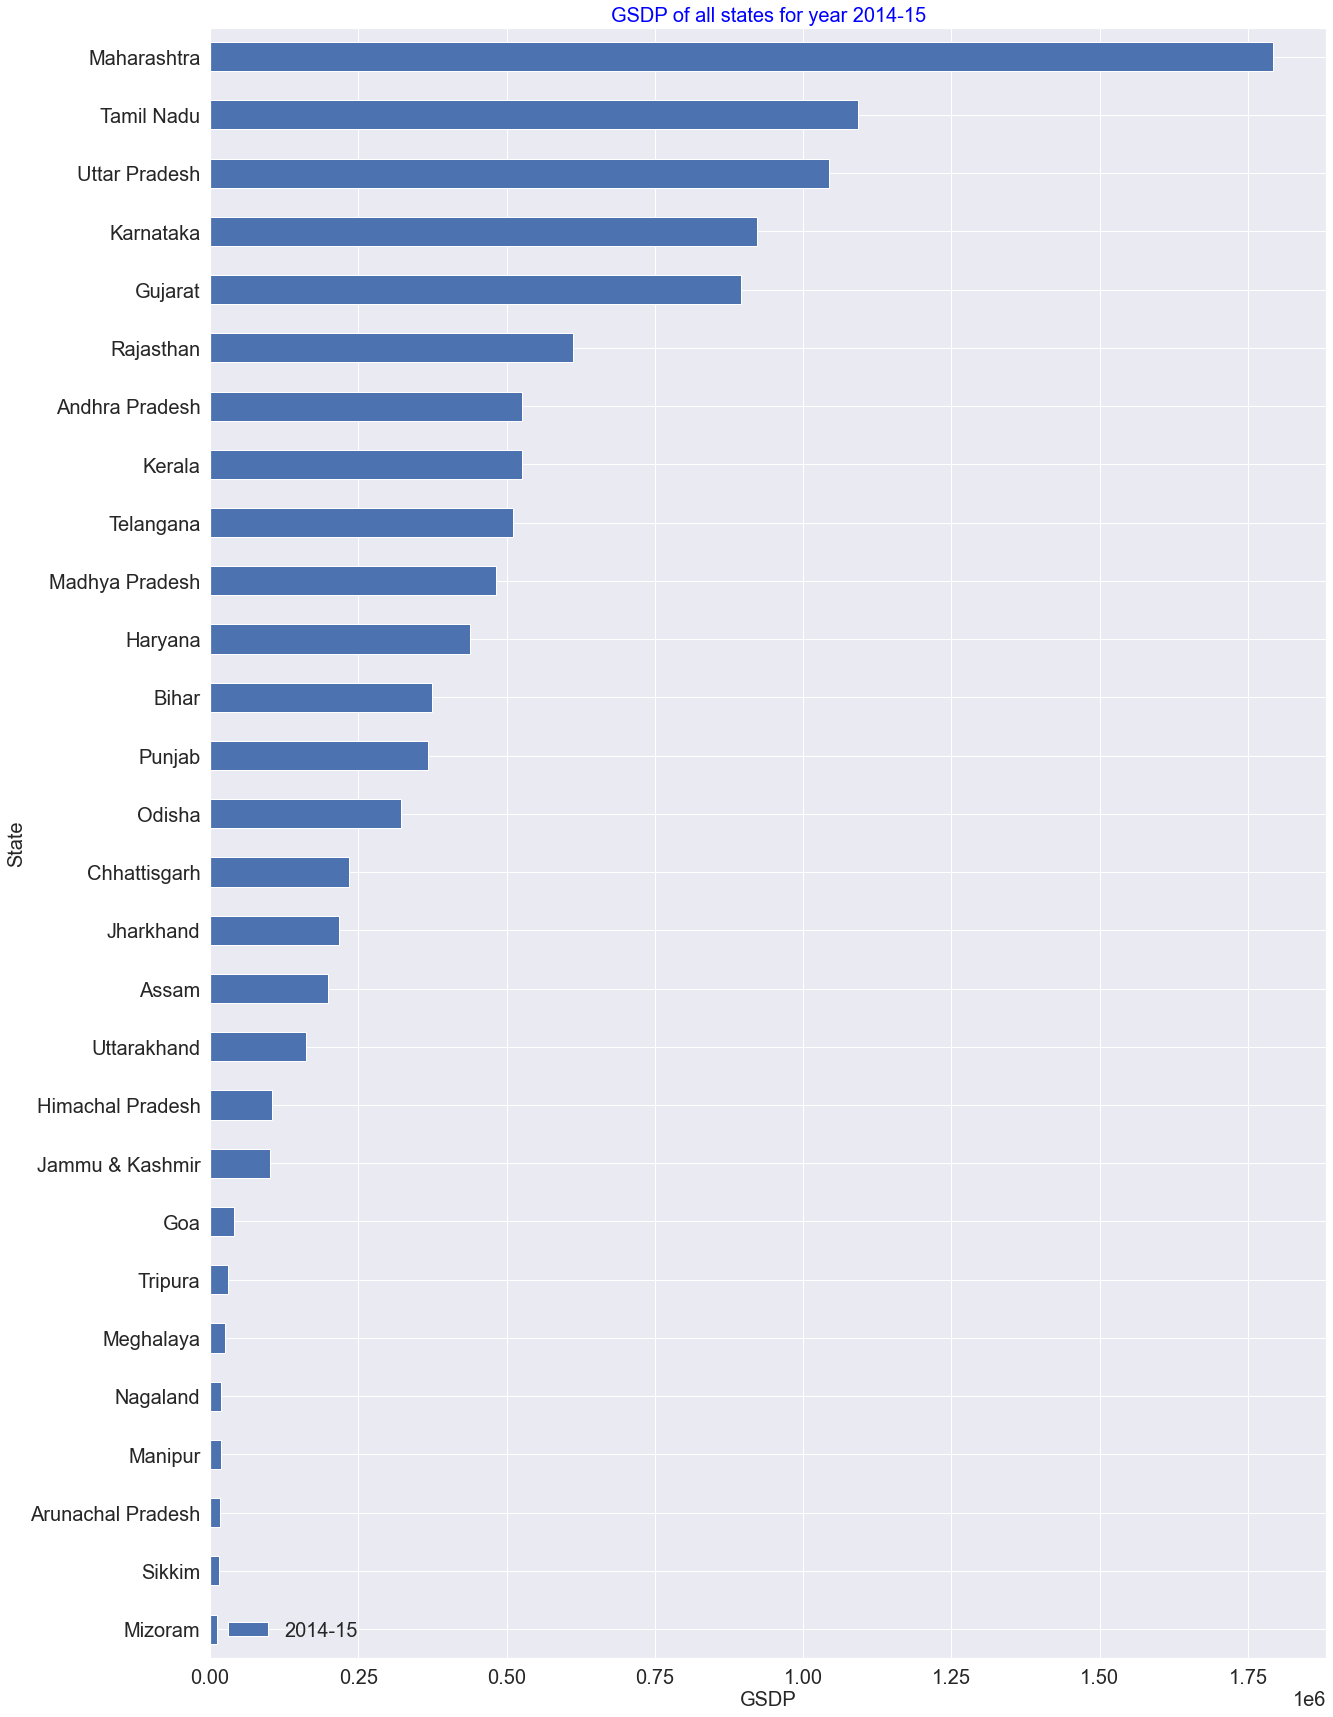

In [28]:
gsdp_copy_df1=gsdp_df.copy()
gsdp_copy_df1=gsdp_copy_df1[gsdp_copy_df1['Duration']=='2014-15']
gsdp_transpose_df1 = gsdp_copy_df1.T
gsdp_transpose_df1.rename(columns={3:'2014-15'},inplace=True)
gsdp_transpose_df1 = gsdp_transpose_df1[1:].sort_values(by='2014-15',ascending=False)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
gsdp_transpose_df1[1:].dropna().sort_values(by='2014-15',ascending=True).plot(kind='barh',
          figsize=(20,30));
plt.title('GSDP of all states for year 2014-15',color='blue')
plt.ylabel('State')
plt.xlabel('GSDP');

In [69]:
import re
path = './datasets/states/*.csv'
all_files = glob.glob(path)
files_list=[]
AllStates_datacheck = pd.DataFrame(index=['Missingness','Duplicates'])
States_data_list = []
# print(all_files)
for filename in all_files:
#     print(filename)
#     ##find the state name from the file name using split function
    state = filename.split("\\")[1].split(".")[0]
#     print(state)
    state_df = pd.read_csv(filename,index_col=None,header=0,encoding = 'unicode_escape')
    
    ## As per the given instructions - for Part - IB - Also, perform the analysis only for the duration 2014-15. 
    state_df = state_df[['S.No.','Item','2014-15']]
    
    # As per the assignment - percentage contribution of the primary, secondary and tertiary sectors 
    ## as a percentage of the total GDP for all the states.
    ## based on this drop the sub-sub sectors
    
    state_df.drop(state_df.loc[state_df['S.No.'].isin(['1.1','1.2','1.3','1.4','6.1','6.2',
                                                   '7.1','7.2','7.3','7.4','7.5','7.6','7.7'])].index,inplace=True)
    
    
    ## with given formula to calculate Total GDP of State
    ## Total GSVA = (Primary + Secondary + Tertiary) contributions
    ## GSDP = Total GSVA + Taxes on Products - Subsidies on Products
    ## Since these columns - Total GSVA, Taxes on Product, Subsidies might be needed for ananlysis later
    ## so still keeping these columns in dataframe
    #ignore --> state_df.drop(state_df.loc[state_df['S.No.'].isin(['12','13','14','16'])].index,inplace=True)

    
    ##Transpose the DataFrame
    state_df = state_df.T
    
    ##take the row at index location1 and save it in header variable
    new_header = state_df.iloc[1]
    
    ## select only the row with only relevant values by removing unwanted rows like S.No. etc
    state_df = state_df[2:]
    
    ## set the columns of this dataframe using the header variable
    state_df.columns = new_header
    
    ## Add new column as state name in dataframe
    state_df['State'] = state
    
    ##reshuffle columns and bring State column in front
    col_list = list(state_df.columns)
    col_list = col_list[-1:] + col_list[:-1]
    
    state_df = state_df[col_list]
    
    ## Append the state's dataframe in the list
    States_data_list.append(state_df)

    ## This piece of code will check for missingness and duplicates in each state dataframe
    AllStates_datacheck[state]=[state_df.isnull().sum().sum(),state_df.duplicated().sum()]


## When all files are read and the data is available in final list
## then load that list in dataframe using concatenate function of pandas
all_states_df = pd.concat(States_data_list,axis=0,ignore_index=True)
all_states_df

Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,"Real estate, ownership of dwelling & professional services",Public administration,Other services,Tertiary,TOTAL GSVA at basic prices,Taxes on Products,Subsidies on products,Gross State Domestic Product,Population ('00),Per Capita GSDP (Rs.)
0,Andhra_Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,4405409,2200897,4215389,22032942,48825542,5512100,1690800,52646842,501510,104977
1,Arunachal_Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,48418,243867,218728,631844,1636292,70099,30272,1676119,14870,112718
2,Assam,3855548,1471149,5326697,2002936,296587,1733568,4033091,2987155,1194568,...,1412466,1373611,1795658,9307109,18666897,1725309,582406,19809800,326780,60621
3,Bihar,7951890,68107,8019997,2189965,345168,3449763,5984896,7448373,3147173,...,3740641,2078171,4587589,22179969,36184863,3213546,2006421,37391988,1101240,33954
4,Chandigarh,16233,179,16412,149631,29741,133321,312693,965781,148302,...,598448,183889,156543,2426008,2755113,52622,23309,2784426,11120,250398
5,Chattisgarh,3948847,2451970,6400817,4370593,1198438,2669855,8238886,1535571,871770,...,2462166,867982,1112232,7588778,22228481,2601791,1332092,23498180,270530,86860
6,Delhi,250568,963777,1214345,2749307,971255,2048788,5769350,5896633,5597141,...,11733335,2008191,3829385,36039554,43023249,6611719,392546,49242422,179690,274041
7,Goa,308507,3622,312129,1177608,204110,165819,1547536,380927,189656,...,407099,346486,180431,1738217,3597882,527279,61854,4063307,14950,271793
8,Gujarat,1.377e+07,2.11722e+06,1.58872e+07,2.40875e+07,3.40998e+06,5.52602e+06,3.30235e+07,1.01787e+07,4.55591e+06,...,5.1795e+06,2.5762e+06,3.12341e+06,3.02204e+07,7.91311e+07,1.23532e+07,1.98155e+06,8.95027e+07,633590,141263
9,Haryana,8.01524e+06,25186,8.04042e+06,7.75692e+06,1.10192e+06,3.70257e+06,1.25614e+07,4.98632e+06,2.56062e+06,...,6.97018e+06,1.03638e+06,2.00158e+06,1.92266e+07,3.98284e+07,4.98567e+06,1.06787e+06,4.37462e+07,266620,164077


In [70]:
AllStates_datacheck

,Andhra_Pradesh,Arunachal_Pradesh,Assam,Bihar,Chandigarh,Chattisgarh,Delhi,Goa,Gujarat,Haryana,...,Nagaland,Odisha,Punjab,Rajasthan,Sikkim,Tamil_Nadu,Telenghana,Tripura,Uttarakhand,Uttar_Pradesh
Missingness,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Duplicates,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
### Drop UTs from the dataset
print('No of rows {0} and columns {1} before dropping UTs'.format(all_states_df.shape[0],all_states_df.shape[1]))
all_states_df.drop(all_states_df.loc[all_states_df['State'].isin(
    ['Delhi','Chandigarh','Puducherry'])].index,inplace=True)
print('No of rows {0} and columns {1} after dropping UTs'.format(all_states_df.shape[0],all_states_df.shape[1]))

No of rows 30 and columns 21 before dropping UTs
No of rows 28 and columns 21 after dropping UTs


In [72]:
all_states_df.sort_values(by='Per Capita GSDP (Rs.)',ascending=False)


Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,"Real estate, ownership of dwelling & professional services",Public administration,Other services,Tertiary,TOTAL GSVA at basic prices,Taxes on Products,Subsidies on products,Gross State Domestic Product,Population ('00),Per Capita GSDP (Rs.)
7,Goa,308507,3622,312129,1177608,204110,165819,1547536,380927,189656,...,407099,346486,180431,1738217,3597882,527279,61854,4063307,14950,271793
24,Sikkim,137447,1329,138776,550697,212499,82058,845253,70568,47347,...,75330,119514,149265,483103,1467133,72200,18400,1520933,6330,240274
9,Haryana,8.01524e+06,25186,8.04042e+06,7.75692e+06,1.10192e+06,3.70257e+06,1.25614e+07,4.98632e+06,2.56062e+06,...,6.97018e+06,1.03638e+06,2.00158e+06,1.92266e+07,3.98284e+07,4.98567e+06,1.06787e+06,4.37462e+07,266620,164077
14,Kerala,5930617,558824,6489442,4273567,482470,7314003,12070040,8557345,4020934,...,7287633,2068915,5728645,29673778,48233259,5189352,822381,52600230,339843,154778
28,Uttarakhand,1.60142e+06,244549,1.84597e+06,5.86625e+06,433880,1.34273e+06,7.64286e+06,1.74311e+06,1.06669e+06,...,831307,579409,982430,5.58798e+06,1.50768e+07,1.43486e+06,313139,1.61985e+07,105820,153076
16,Maharashtra,16475655,5282727,21758383,33660294,4334702,9450211,47445207,15839100,9697246,...,30718051,5426991,10806363,88631076,157834665,25394800,4017300,179212165,1172450,152853
10,Himachal_Pradesh,1514981,33385,1548366,2543637,767268,808256,4119162,615496,552234,...,1125937,553974,923164,4133326,9800853,895317,259291,10436879,70840,147330
25,Tamil_Nadu,13064238,265536,13329774,18914794,1710379,12216718,32841892,12895842,7188320,...,16830213,3400800,7430115,53343788,99515453,12507325,2766405,109256373,745760,146503
13,Karnataka,11219422,846882,12066304,12953843,1425762,6104799,20484404,8991658,5097652,...,24766393,2232584,5308174,50490630,83041338,11026674,1889206,92178806,635100,145141
8,Gujarat,1.377e+07,2.11722e+06,1.58872e+07,2.40875e+07,3.40998e+06,5.52602e+06,3.30235e+07,1.01787e+07,4.55591e+06,...,5.1795e+06,2.5762e+06,3.12341e+06,3.02204e+07,7.91311e+07,1.23532e+07,1.98155e+06,8.95027e+07,633590,141263


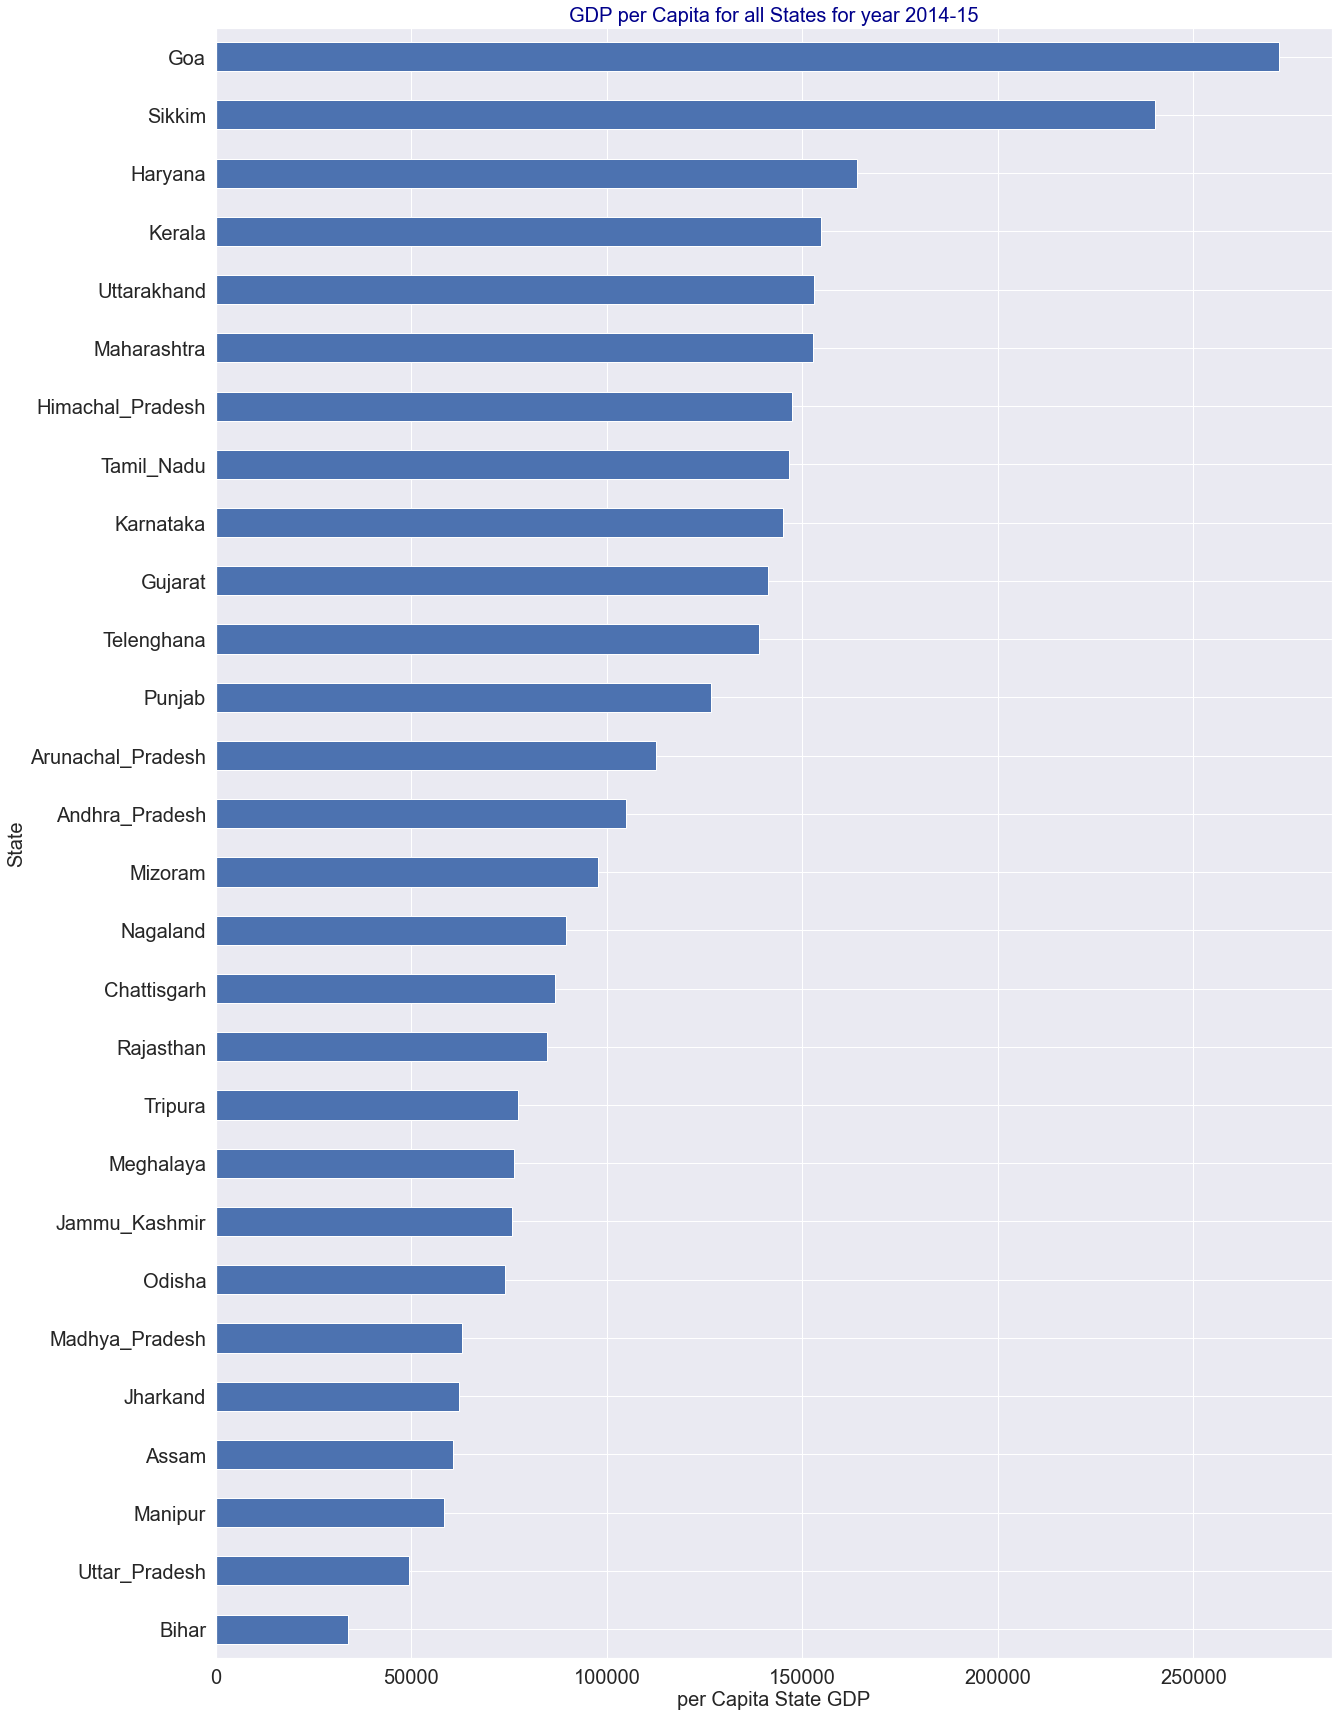

In [73]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.title('GDP per Capita for all States for year 2014-15',color='darkblue')
plt.xlabel('per Capita State GDP')
plt.ylabel('State')
all_states_df.set_index('State')['Per Capita GSDP (Rs.)'].sort_values().plot(kind='barh',figsize=(20,30));

In [74]:
df1 = all_states_df.sort_values(by='Per Capita GSDP (Rs.)',ascending=False)
print('Highest per Capita GDP: {0}'.format(df1.iloc[0]['Per Capita GSDP (Rs.)']))
print('Lowest per Capita GDP: {0}'.format(df1.iloc[df1.shape[0]-1]['Per Capita GSDP (Rs.)']))
ratio = round(df1.iloc[0]['Per Capita GSDP (Rs.)']/df1.iloc[df1.shape[0]-1]['Per Capita GSDP (Rs.)'],2)
print('Ratio of highest per capita GDP to the lowest per capita GDP: {0}'.format(ratio))

Highest per Capita GDP: 271793
Lowest per Capita GDP: 33954
Ratio of highest per capita GDP to the lowest per capita GDP: 8.0


In [75]:

all_states_df['Primary_Perc'] = ((all_states_df['Primary']/all_states_df['Gross State Domestic Product'])*100).astype(float).round(2)
all_states_df['Secondary_Perc'] = ((all_states_df['Secondary']/all_states_df['Gross State Domestic Product'])*100).astype(float).round(2)
all_states_df['Tertiary_Perc'] = ((all_states_df['Tertiary']/all_states_df['Gross State Domestic Product'])*100).astype(float).round(2)
all_states_df['Taxes_Perc'] = ((all_states_df['Taxes on Products']/all_states_df['Gross State Domestic Product'])*100).astype(float).round(2)
all_states_df['Subsidies_Perc'] = ((all_states_df['Subsidies on products']/all_states_df['Gross State Domestic Product'])*100).astype(float).round(2)
all_states_df['AllSectors_Perc'] = all_states_df['Primary_Perc'
                                                ] + all_states_df['Secondary_Perc'
                                                                 ] + all_states_df['Tertiary_Perc']
all_states_df

Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,Subsidies on products,Gross State Domestic Product,Population ('00),Per Capita GSDP (Rs.),Primary_Perc,Secondary_Perc,Tertiary_Perc,Taxes_Perc,Subsidies_Perc,AllSectors_Perc
0,Andhra_Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,1690800,52646842,501510,104977,30.97,19.92,41.85,10.47,3.21,92.74
1,Arunachal_Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,30272,1676119,14870,112718,42.77,17.15,37.70,4.18,1.81,97.62
2,Assam,3855548,1471149,5326697,2002936,296587,1733568,4033091,2987155,1194568,...,582406,19809800,326780,60621,26.89,20.36,46.98,8.71,2.94,94.23
3,Bihar,7951890,68107,8019997,2189965,345168,3449763,5984896,7448373,3147173,...,2006421,37391988,1101240,33954,21.45,16.01,59.32,8.59,5.37,96.78
5,Chattisgarh,3948847,2451970,6400817,4370593,1198438,2669855,8238886,1535571,871770,...,1332092,23498180,270530,86860,27.24,35.06,32.30,11.07,5.67,94.60
7,Goa,308507,3622,312129,1177608,204110,165819,1547536,380927,189656,...,61854,4063307,14950,271793,7.68,38.09,42.78,12.98,1.52,88.55
8,Gujarat,1.377e+07,2.11722e+06,1.58872e+07,2.40875e+07,3.40998e+06,5.52602e+06,3.30235e+07,1.01787e+07,4.55591e+06,...,1.98155e+06,8.95027e+07,633590,141263,17.75,36.90,33.76,13.80,2.21,88.41
9,Haryana,8.01524e+06,25186,8.04042e+06,7.75692e+06,1.10192e+06,3.70257e+06,1.25614e+07,4.98632e+06,2.56062e+06,...,1.06787e+06,4.37462e+07,266620,164077,18.38,28.71,43.95,11.40,2.44,91.04
10,Himachal_Pradesh,1514981,33385,1548366,2543637,767268,808256,4119162,615496,552234,...,259291,10436879,70840,147330,14.84,39.47,39.60,8.58,2.48,93.91
11,Jammu_Kashmir,1586705,33621,1620326,893207,597421,785503,2276132,889931,712552,...,233563,10040446,132390,75840,16.14,22.67,55.91,7.61,2.33,94.72


In [76]:

sort_gsdp_df = all_states_df.sort_values(by='Gross State Domestic Product',ascending=True)
sort_gsdp_df.sort_values(by='Gross State Domestic Product',ascending=False)

Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,Subsidies on products,Gross State Domestic Product,Population ('00),Per Capita GSDP (Rs.),Primary_Perc,Secondary_Perc,Tertiary_Perc,Taxes_Perc,Subsidies_Perc,AllSectors_Perc
16,Maharashtra,16475655,5282727,21758383,33660294,4334702,9450211,47445207,15839100,9697246,...,4017300,179212165,1172450,152853,12.14,26.47,49.46,14.17,2.24,88.07
25,Tamil_Nadu,13064238,265536,13329774,18914794,1710379,12216718,32841892,12895842,7188320,...,2766405,109256373,745760,146503,12.20,30.06,48.82,11.45,2.53,91.08
29,Uttar_Pradesh,25097754,901501,25999255,12261649,2030625,11256450,25548724,9437243,7404509,...,3287219,104337115,2109940,49450,24.92,24.49,44.06,9.69,3.15,93.47
13,Karnataka,11219422,846882,12066304,12953843,1425762,6104799,20484404,8991658,5097652,...,1889206,92178806,635100,145141,13.09,22.22,54.77,11.96,2.05,90.08
8,Gujarat,1.377e+07,2.11722e+06,1.58872e+07,2.40875e+07,3.40998e+06,5.52602e+06,3.30235e+07,1.01787e+07,4.55591e+06,...,1.98155e+06,8.95027e+07,633590,141263,17.75,36.90,33.76,13.80,2.21,88.41
23,Rajasthan,15044394,4069385,19113780,6552580,1122888,5353326,13028794,7297290,3814461,...,2333442,61219447,721610,84837,31.22,21.28,42.50,8.81,3.81,95.00
0,Andhra_Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,1690800,52646842,501510,104977,30.97,19.92,41.85,10.47,3.21,92.74
14,Kerala,5930617,558824,6489442,4273567,482470,7314003,12070040,8557345,4020934,...,822381,52600230,339843,154778,12.34,22.95,56.41,9.87,1.56,91.70
26,Telenghana,7591501,1541853,9133354,6353711,716266,2854024,9924001,6494607,3604741,...,836700,51117765,367660,139035,17.87,19.41,55.70,8.66,1.64,92.98
15,Madhya_Pradesh,16235647,1618373,17854020,4368833,1272905,4403151,10044889,5357515,2865802,...,2102800,48198169,765180,62989,37.04,20.84,37.59,8.89,4.36,95.47


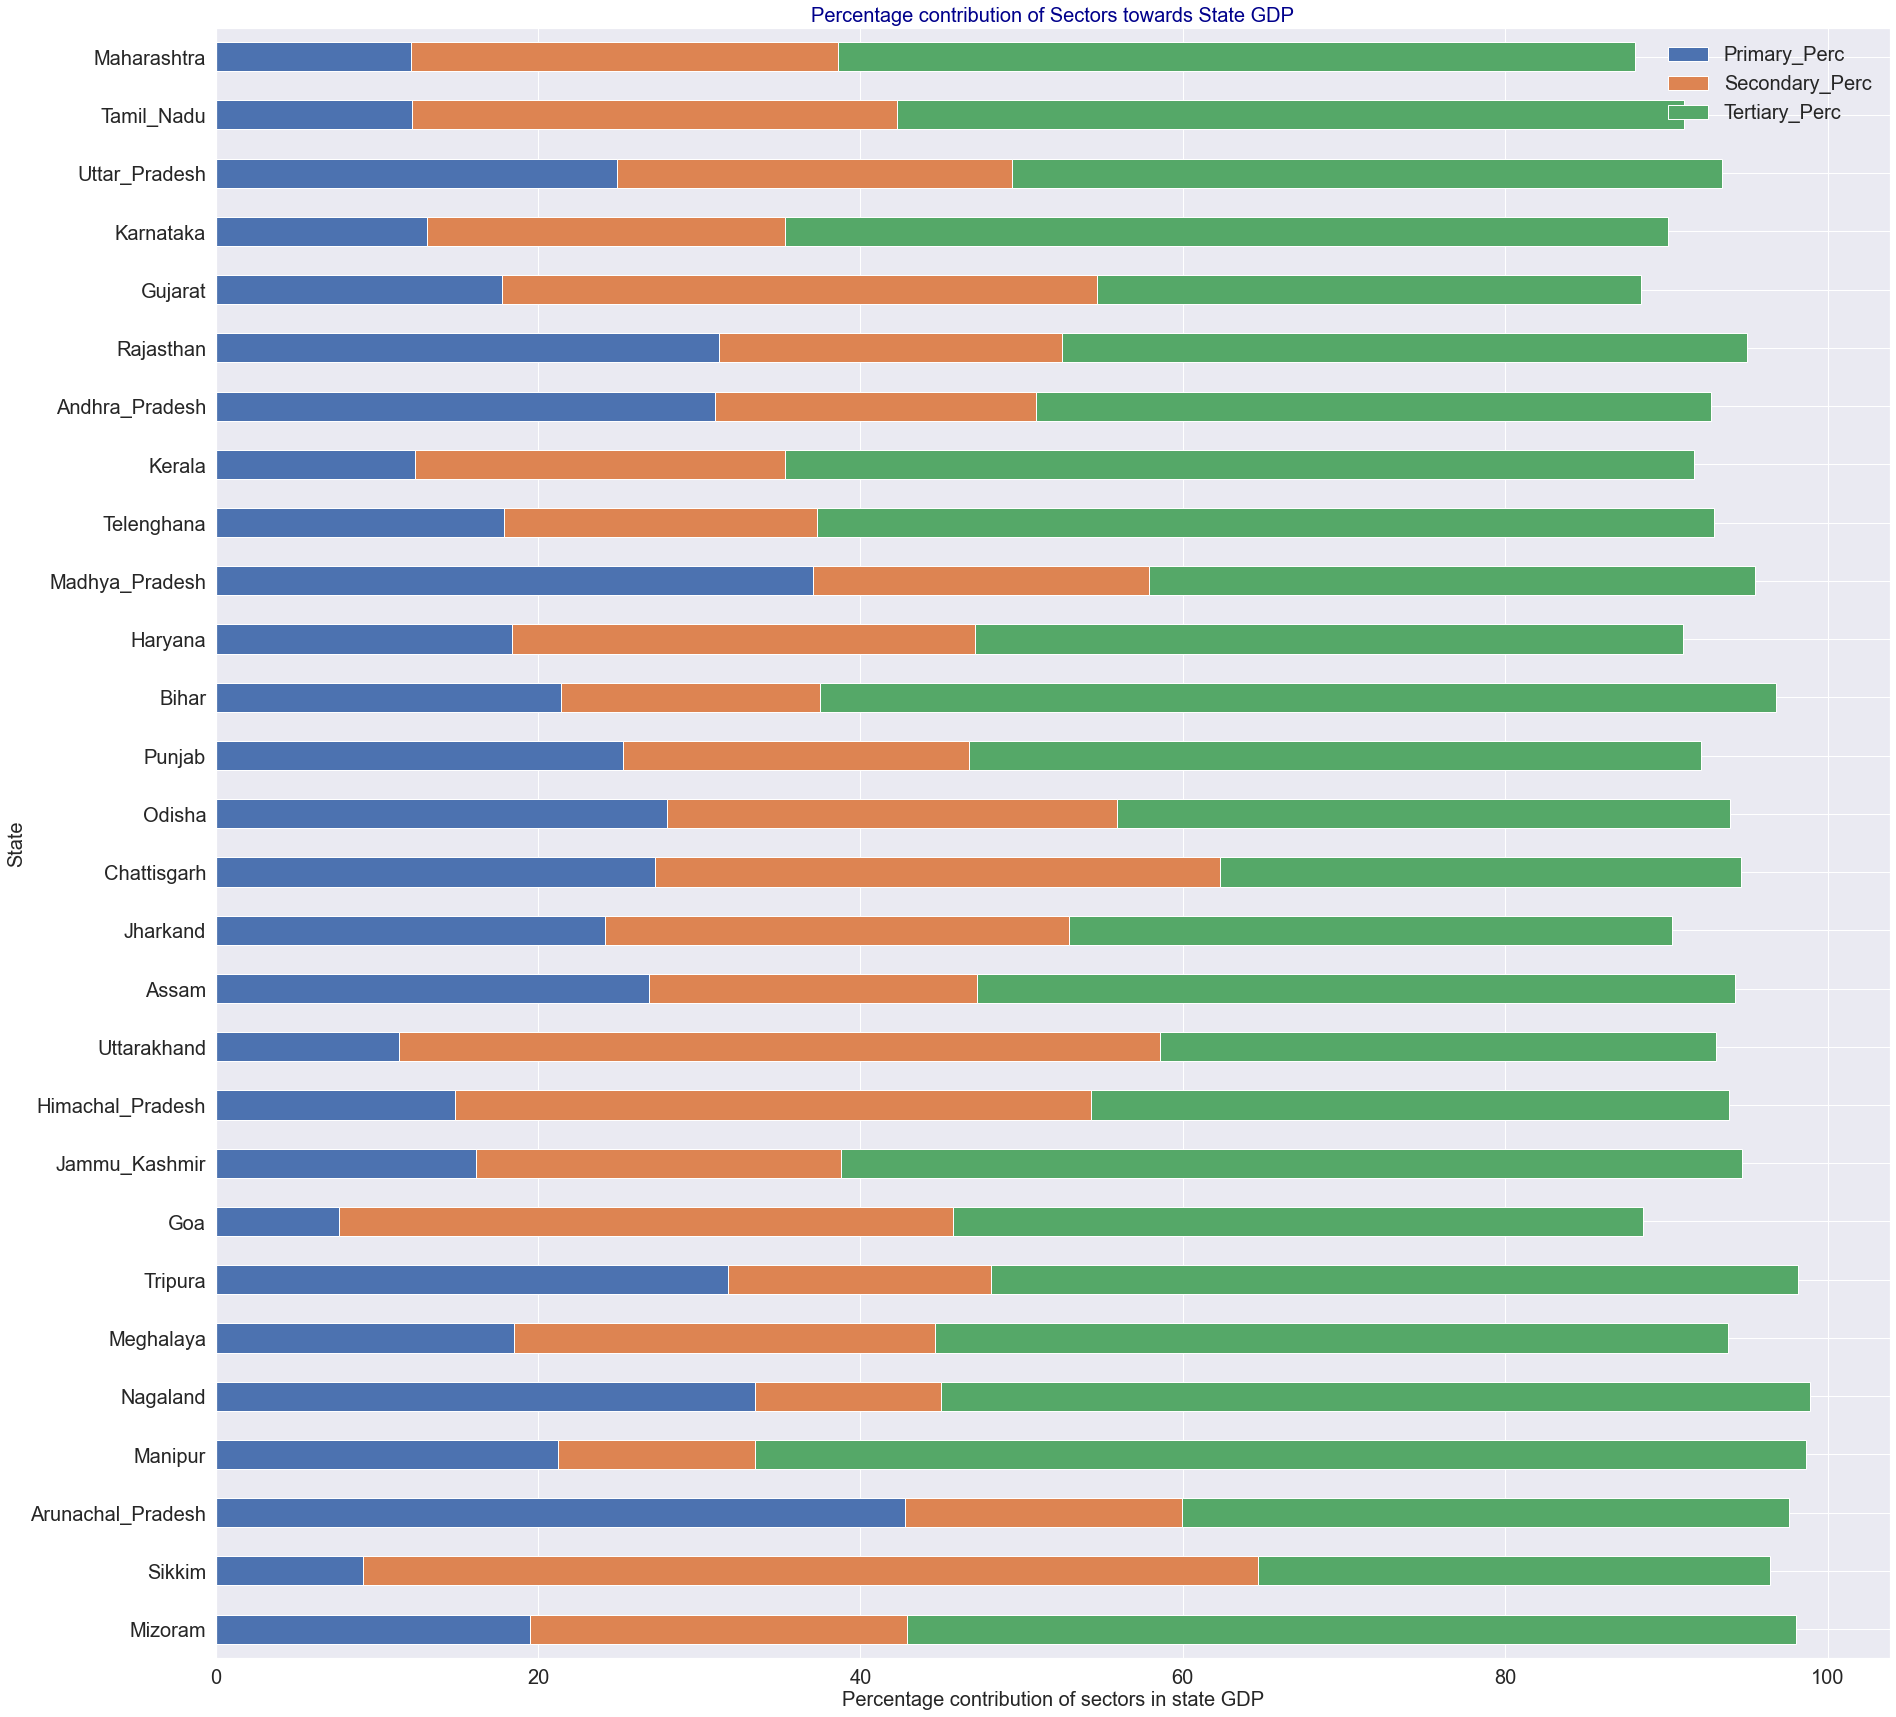

In [77]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sort_gsdp_df[['State','Primary_Perc','Secondary_Perc','Tertiary_Perc']
            ].set_index('State').plot(kind='barh',stacked=True,figsize=(30,30));
plt.title('Percentage contribution of Sectors towards State GDP',color='darkblue')
plt.xlabel('Percentage contribution of sectors in state GDP')
plt.ylabel('State');
plt.legend();

In [78]:
all_states_df['Percentile_Rank'] = round(all_states_df['Gross State Domestic Product'].rank(pct=True),2)
all_states_df

Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,Gross State Domestic Product,Population ('00),Per Capita GSDP (Rs.),Primary_Perc,Secondary_Perc,Tertiary_Perc,Taxes_Perc,Subsidies_Perc,AllSectors_Perc,Percentile_Rank
0,Andhra_Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,52646842,501510,104977,30.97,19.92,41.85,10.47,3.21,92.74,0.79
1,Arunachal_Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,1676119,14870,112718,42.77,17.15,37.70,4.18,1.81,97.62,0.11
2,Assam,3855548,1471149,5326697,2002936,296587,1733568,4033091,2987155,1194568,...,19809800,326780,60621,26.89,20.36,46.98,8.71,2.94,94.23,0.43
3,Bihar,7951890,68107,8019997,2189965,345168,3449763,5984896,7448373,3147173,...,37391988,1101240,33954,21.45,16.01,59.32,8.59,5.37,96.78,0.61
5,Chattisgarh,3948847,2451970,6400817,4370593,1198438,2669855,8238886,1535571,871770,...,23498180,270530,86860,27.24,35.06,32.30,11.07,5.67,94.60,0.50
7,Goa,308507,3622,312129,1177608,204110,165819,1547536,380927,189656,...,4063307,14950,271793,7.68,38.09,42.78,12.98,1.52,88.55,0.29
8,Gujarat,1.377e+07,2.11722e+06,1.58872e+07,2.40875e+07,3.40998e+06,5.52602e+06,3.30235e+07,1.01787e+07,4.55591e+06,...,8.95027e+07,633590,141263,17.75,36.90,33.76,13.80,2.21,88.41,0.86
9,Haryana,8.01524e+06,25186,8.04042e+06,7.75692e+06,1.10192e+06,3.70257e+06,1.25614e+07,4.98632e+06,2.56062e+06,...,4.37462e+07,266620,164077,18.38,28.71,43.95,11.40,2.44,91.04,0.64
10,Himachal_Pradesh,1514981,33385,1548366,2543637,767268,808256,4119162,615496,552234,...,10436879,70840,147330,14.84,39.47,39.60,8.58,2.48,93.91,0.36
11,Jammu_Kashmir,1586705,33621,1620326,893207,597421,785503,2276132,889931,712552,...,10040446,132390,75840,16.14,22.67,55.91,7.61,2.33,94.72,0.32


In [79]:
all_states_df['Percentile_Corr'] = round(all_states_df['Primary_Perc'].corr(all_states_df['Percentile_Rank']),2)
all_states_df

Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,Population ('00),Per Capita GSDP (Rs.),Primary_Perc,Secondary_Perc,Tertiary_Perc,Taxes_Perc,Subsidies_Perc,AllSectors_Perc,Percentile_Rank,Percentile_Corr
0,Andhra_Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,501510,104977,30.97,19.92,41.85,10.47,3.21,92.74,0.79,-0.12
1,Arunachal_Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,14870,112718,42.77,17.15,37.70,4.18,1.81,97.62,0.11,-0.12
2,Assam,3855548,1471149,5326697,2002936,296587,1733568,4033091,2987155,1194568,...,326780,60621,26.89,20.36,46.98,8.71,2.94,94.23,0.43,-0.12
3,Bihar,7951890,68107,8019997,2189965,345168,3449763,5984896,7448373,3147173,...,1101240,33954,21.45,16.01,59.32,8.59,5.37,96.78,0.61,-0.12
5,Chattisgarh,3948847,2451970,6400817,4370593,1198438,2669855,8238886,1535571,871770,...,270530,86860,27.24,35.06,32.30,11.07,5.67,94.60,0.50,-0.12
7,Goa,308507,3622,312129,1177608,204110,165819,1547536,380927,189656,...,14950,271793,7.68,38.09,42.78,12.98,1.52,88.55,0.29,-0.12
8,Gujarat,1.377e+07,2.11722e+06,1.58872e+07,2.40875e+07,3.40998e+06,5.52602e+06,3.30235e+07,1.01787e+07,4.55591e+06,...,633590,141263,17.75,36.90,33.76,13.80,2.21,88.41,0.86,-0.12
9,Haryana,8.01524e+06,25186,8.04042e+06,7.75692e+06,1.10192e+06,3.70257e+06,1.25614e+07,4.98632e+06,2.56062e+06,...,266620,164077,18.38,28.71,43.95,11.40,2.44,91.04,0.64,-0.12
10,Himachal_Pradesh,1514981,33385,1548366,2543637,767268,808256,4119162,615496,552234,...,70840,147330,14.84,39.47,39.60,8.58,2.48,93.91,0.36,-0.12
11,Jammu_Kashmir,1586705,33621,1620326,893207,597421,785503,2276132,889931,712552,...,132390,75840,16.14,22.67,55.91,7.61,2.33,94.72,0.32,-0.12


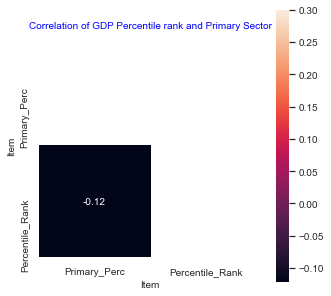

In [80]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
numeric_col_heatmap = ['Primary_Perc','Percentile_Rank']
plt.figure(figsize=(5,5))
mask = np.zeros_like(all_states_df[numeric_col_heatmap].corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
      sns.heatmap(all_states_df[numeric_col_heatmap].corr(),mask=mask,vmax=.3, square=True, annot=True,
                 );#cmap='RdYlGn');
plt.title("Correlation of GDP Percentile rank and Primary Sector",color='blue');

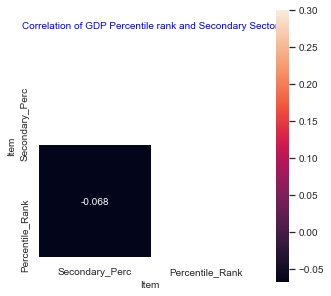

In [81]:
numeric_col_heatmap = ['Secondary_Perc','Percentile_Rank']
plt.figure(figsize=(5,5))
mask = np.zeros_like(all_states_df[numeric_col_heatmap].corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
      sns.heatmap(all_states_df[numeric_col_heatmap].corr(),mask=mask,vmax=.3, square=True, annot=True,
                 );#cmap='RdYlGn');
plt.title("Correlation of GDP Percentile rank and Secondary Sector",color='blue');

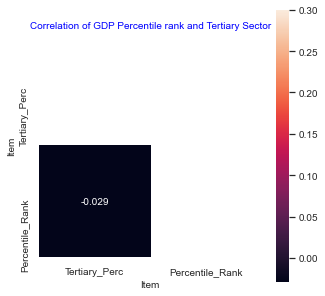

In [82]:
numeric_col_heatmap = ['Tertiary_Perc','Percentile_Rank']
plt.figure(figsize=(5,5))
mask = np.zeros_like(all_states_df[numeric_col_heatmap].corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
      sns.heatmap(all_states_df[numeric_col_heatmap].corr(),mask=mask,vmax=.3, square=True, annot=True,
                 );#cmap='RdYlGn');
plt.title("Correlation of GDP Percentile rank and Tertiary Sector",color='blue');

In [83]:
state_category_df = all_states_df.copy()
category_labels = ['C4', 'C3', 'C2', 'C1']
state_category_df['Category'] = pd.qcut(state_category_df['Per Capita GSDP (Rs.)'],
                              q=[0, 0.2, .5, .85, 1],
                              labels=category_labels)
state_category_df

Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,Per Capita GSDP (Rs.),Primary_Perc,Secondary_Perc,Tertiary_Perc,Taxes_Perc,Subsidies_Perc,AllSectors_Perc,Percentile_Rank,Percentile_Corr,Category
0,Andhra_Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,104977,30.97,19.92,41.85,10.47,3.21,92.74,0.79,-0.12,C2
1,Arunachal_Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,112718,42.77,17.15,37.70,4.18,1.81,97.62,0.11,-0.12,C2
2,Assam,3855548,1471149,5326697,2002936,296587,1733568,4033091,2987155,1194568,...,60621,26.89,20.36,46.98,8.71,2.94,94.23,0.43,-0.12,C4
3,Bihar,7951890,68107,8019997,2189965,345168,3449763,5984896,7448373,3147173,...,33954,21.45,16.01,59.32,8.59,5.37,96.78,0.61,-0.12,C4
5,Chattisgarh,3948847,2451970,6400817,4370593,1198438,2669855,8238886,1535571,871770,...,86860,27.24,35.06,32.30,11.07,5.67,94.60,0.50,-0.12,C3
7,Goa,308507,3622,312129,1177608,204110,165819,1547536,380927,189656,...,271793,7.68,38.09,42.78,12.98,1.52,88.55,0.29,-0.12,C1
8,Gujarat,1.377e+07,2.11722e+06,1.58872e+07,2.40875e+07,3.40998e+06,5.52602e+06,3.30235e+07,1.01787e+07,4.55591e+06,...,141263,17.75,36.90,33.76,13.80,2.21,88.41,0.86,-0.12,C2
9,Haryana,8.01524e+06,25186,8.04042e+06,7.75692e+06,1.10192e+06,3.70257e+06,1.25614e+07,4.98632e+06,2.56062e+06,...,164077,18.38,28.71,43.95,11.40,2.44,91.04,0.64,-0.12,C1
10,Himachal_Pradesh,1514981,33385,1548366,2543637,767268,808256,4119162,615496,552234,...,147330,14.84,39.47,39.60,8.58,2.48,93.91,0.36,-0.12,C2
11,Jammu_Kashmir,1586705,33621,1620326,893207,597421,785503,2276132,889931,712552,...,75840,16.14,22.67,55.91,7.61,2.33,94.72,0.32,-0.12,C3


In [84]:
state_category_df['Per Capita GSDP (Rs.)'].quantile(0.5)

101332.0

In [85]:
def plot_cetgory(df_category_state,category_list):
    sns.set(font_scale=1)
    nrows = int(np.ceil(len(category_list))) # Makes sure you have enough rows
    #tweak figsize scaler if graphs don't fit well
    fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(8,8*len(category_list)), sharex=False, sharey=False)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    for i, category in enumerate(category_list):
        
        ##Filter dataframe based on category
        df2_copy_df= df_category_state[df_category_state['Category']==category]
        #since we have already filtered catgeory so we can drop the category in this dataframe
        df2_copy_df.drop(columns=['Primary','Secondary','Tertiary','TOTAL GSVA at basic prices',
                                 'Taxes on Products','Subsidies on products',"Population ('00)",'Primary_Perc',
                        'Secondary_Perc','Tertiary_Perc','AllSectors_Perc','Taxes_Perc','Subsidies_Perc','Category'],
                        inplace=True)

        ##Transpose the data
        df2_copy_df = df2_copy_df.T

        ##take the row at index location1 and save it in header variable
        new_header = df2_copy_df.iloc[0]
        df2_copy_df.columns = new_header

        df2_copy_df = df2_copy_df[1:]

        # Create Total column - this is the total of each sub-sector across all states
        df2_copy_df['Total'] = df2_copy_df.sum(axis=1)

        # Get Total GSDP of all states belonging to that selected category
        total_gsdp = df2_copy_df.loc['Gross State Domestic Product']['Total']
        
        # Create column of sectorwise percentage wrt Total GSDP
        df2_copy_df['Sector_Per']=round(df2_copy_df['Total']/total_gsdp,2)*100
        
        # Sort the values by Sector wise percentage in descending order
        df2_copy_df.sort_values(by='Sector_Per',ascending=False,inplace=True)
        df2_copy_df

        # taking subset of above dataframe to remove GSDP ratio from dataframe
        df2_copy_df = df2_copy_df[1:]

        # Take cumulative sum of sector wise percentage
        df2_copy_df['Cum_Sum'] = df2_copy_df['Sector_Per'].cumsum()

    #     df2_copy_df[df2_copy_df['Cum_Sum']<80]['Cum_Sum'].plot(kind='barh',figsize=(8,8));
    #     plt.title('Sectors that contribute to approximately 80% of the GSDP of category: {0}'.format(category),
    #               color='blue')
    #     plt.xlabel('Cumulative Sum of Sub Sectors percentage')
    #     plt.ylabel('Sub Sectors')
        #sns.barplot(df2_copy_df[df2_copy_df['Cum_Sum']<80]['Cum_Sum'], ax=ax[i])
        
        # Plot the cumulative sum of percentage of sub sectors that contribute to 80% of GSDP. Select only top 5
        df2_copy_df[df2_copy_df['Cum_Sum']<80]['Sector_Per'][0:5].sort_values().plot(kind='barh',ax=ax[i])
        ax[i].set_title('Sub Sectors that contribute to approximately 80% of the GSDP of category: {0}'.format(category),
                        color='blue')
        ax[i].set_xlabel('Sub Sectors %Contribution') 
        ax[i].set_ylabel('Sub Sectors')

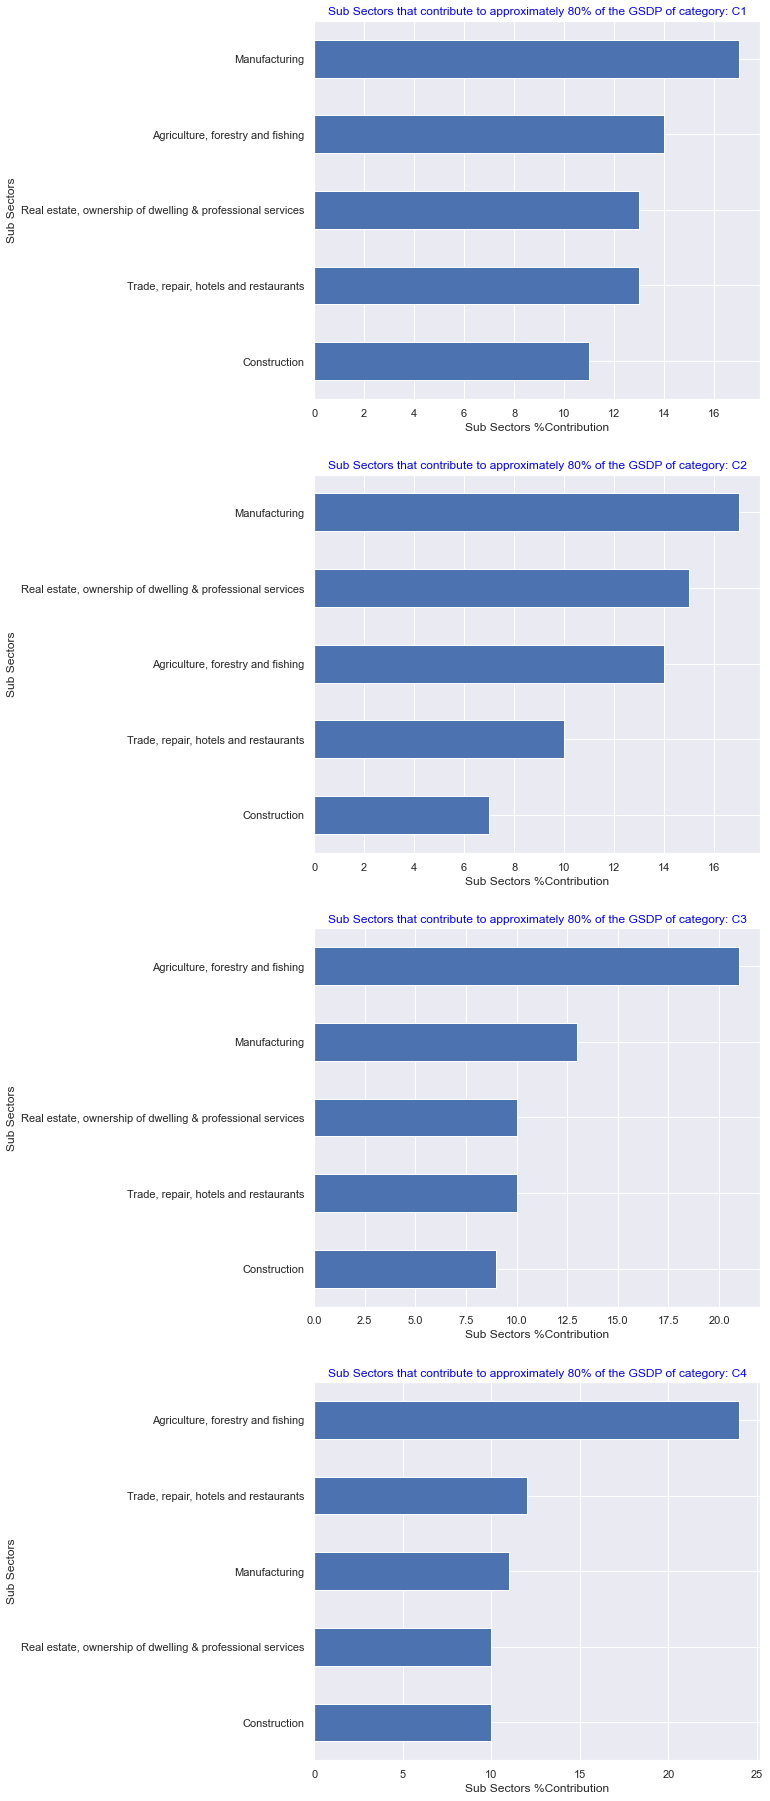

In [86]:
#create category list
category_list = ['C1','C2','C3','C4']

#Call the function to subplot subsectors that contribute to 80% of GSDP - categorywise
plot_cetgory(state_category_df,category_list)

In [87]:
#pd.options.display.float_format = "{:.0f}".format
c1_cat_df= state_category_df[state_category_df['Category']=='C1']
c1_cat_df[['State','Per Capita GSDP (Rs.)','Category']].sort_values(by='Per Capita GSDP (Rs.)',ascending=False)

Item,State,Per Capita GSDP (Rs.),Category
7,Goa,271793,C1
24,Sikkim,240274,C1
9,Haryana,164077,C1
14,Kerala,154778,C1
28,Uttarakhand,153076,C1


In [88]:
c2_cat_df= state_category_df[state_category_df['Category']=='C2']
c2_cat_df[['State','Per Capita GSDP (Rs.)','Category']].sort_values(by='Per Capita GSDP (Rs.)',ascending=False)

Item,State,Per Capita GSDP (Rs.),Category
16,Maharashtra,152853,C2
10,Himachal_Pradesh,147330,C2
25,Tamil_Nadu,146503,C2
13,Karnataka,145141,C2
8,Gujarat,141263,C2
26,Telenghana,139035,C2
22,Punjab,126606,C2
1,Arunachal_Pradesh,112718,C2
0,Andhra_Pradesh,104977,C2


In [89]:
c3_cat_df= state_category_df[state_category_df['Category']=='C3']
c3_cat_df[['State','Per Capita GSDP (Rs.)','Category']].sort_values(by='Per Capita GSDP (Rs.)',ascending=False)

Item,State,Per Capita GSDP (Rs.),Category
19,Mizoram,97687,C3
20,Nagaland,89607,C3
5,Chattisgarh,86860,C3
23,Rajasthan,84837,C3
27,Tripura,77358,C3
18,Meghalaya,76228,C3
11,Jammu_Kashmir,75840,C3
21,Odisha,73979,C3


In [90]:
c4_cat_df= state_category_df[state_category_df['Category']=='C4']
c4_cat_df[['State','Per Capita GSDP (Rs.)','Category']].sort_values(by='Per Capita GSDP (Rs.)',ascending=False)


Item,State,Per Capita GSDP (Rs.),Category
15,Madhya_Pradesh,62989,C4
12,Jharkand,62091,C4
2,Assam,60621,C4
17,Manipur,58442,C4
29,Uttar_Pradesh,49450,C4
3,Bihar,33954,C4


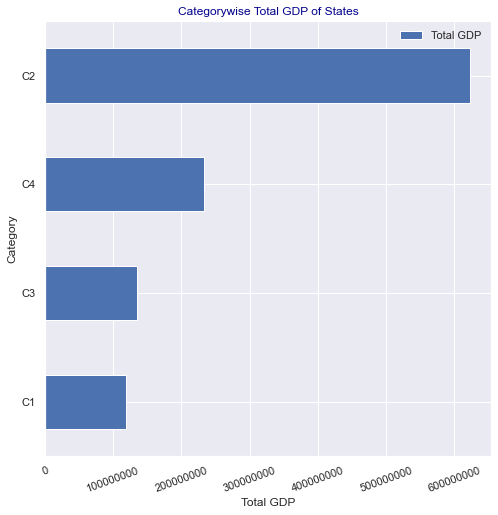

In [91]:
#create category list
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
category_list = ['C1','C2','C3','C4']
df1 = pd.DataFrame(columns=['C1','C2','C3','C4'])
#Call the function to subplot Cetegorywise GDP dstribution of various states
for category in category_list:
    df1['{0}'.format(category)]= [state_category_df[state_category_df['Category']==category
                                                            ]['Gross State Domestic Product'].sum()]
df1 = df1.T.rename(columns={0:'Total GDP'}).sort_values(by='Total GDP',ascending=True)
df1.plot(kind='barh',figsize=(8,8));
plt.title('Categorywise Total GDP of States',color='darkblue')
plt.xlabel('Total GDP')
plt.ylabel('Category');
plt.ticklabel_format(axis="x", style='plain')
plt.xticks(rotation=20);
#plt.xticks(range(10000000,900000000,80000000),rotation=20);

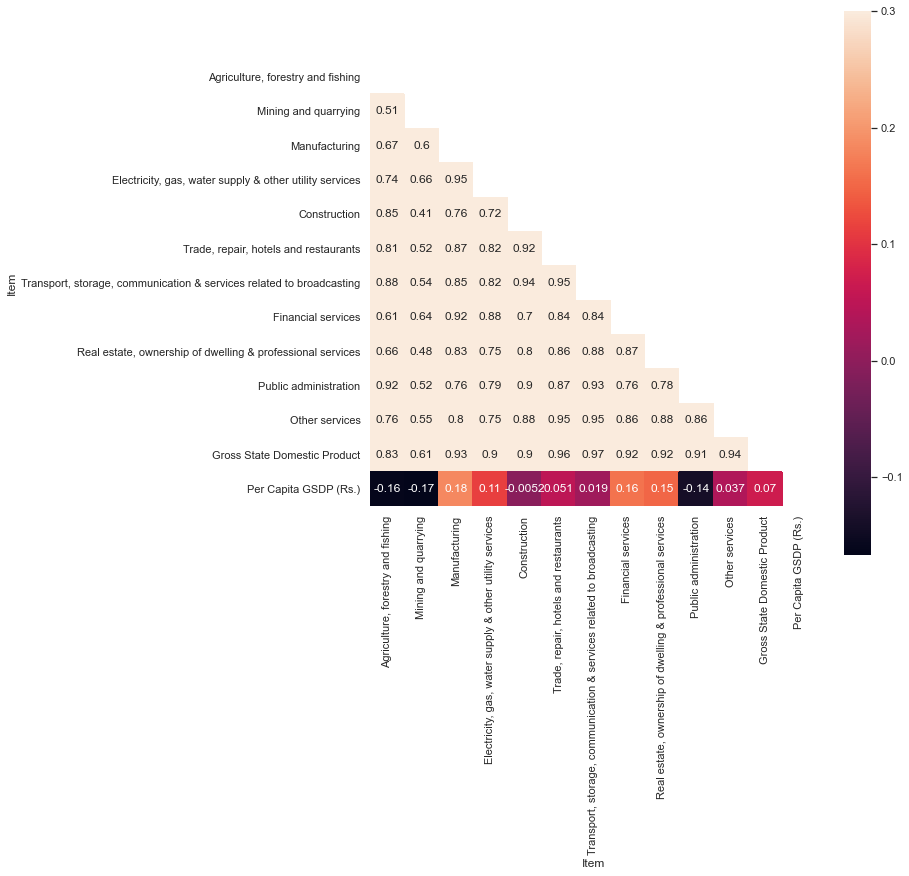

In [92]:
#
states_cat_df = state_category_df.copy()
# drop unnecessary columns from dataframe
states_cat_df.drop(columns=['Primary','Secondary','Tertiary','TOTAL GSVA at basic prices',
                            'Taxes on Products','Subsidies on products',
                            "Population ('00)",'Primary_Perc','Secondary_Perc',
                            'Tertiary_Perc','AllSectors_Perc','Taxes_Perc','Subsidies_Perc',
                            'Percentile_Rank','Percentile_Corr','Category'],inplace=True)
numeric_cols = [col for col in states_cat_df if (col!='State')]
states_cat_df[numeric_cols] = states_cat_df[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)
#states_cat_df.info()

plt.figure(figsize=(10,10))
mask = np.zeros_like(states_cat_df.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
      sns.heatmap(states_cat_df.corr(),mask=mask,vmax=.3, square=True, annot=True,
                 );#cmap='RdYlGn');

In [93]:
def plot_subsector_performance(df_category_state,category_list):
    sns.set(font_scale=1)
    nrows = int(np.ceil(len(category_list))) # Makes sure you have enough rows
    #tweak figsize scaler if graphs don't fit well
    fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(8,8*len(category_list)), sharex=False, sharey=False)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    for i, category in enumerate(category_list):
        
        ##Filter dataframe based on category
        df2_copy_df= df_category_state[df_category_state['Category']==category]
        #since we have already filtered catgeory so we can drop the category in this dataframe
        df2_copy_df.drop(columns=['Primary','Secondary','Tertiary','TOTAL GSVA at basic prices',
                                    'Taxes on Products','Subsidies on products',
                                    "Population ('00)",'Primary_Perc','Secondary_Perc',
                                    'Tertiary_Perc','AllSectors_Perc','Taxes_Perc','Subsidies_Perc',
                                    'Percentile_Rank','Percentile_Corr','Category','Per Capita GSDP (Rs.)',
                                 'Gross State Domestic Product'],
                        inplace=True)

        ##Transpose the data
        df2_copy_df = df2_copy_df.T

        ##take the row at index location1 and save it in header variable
        new_header = df2_copy_df.iloc[0]
        df2_copy_df.columns = new_header

        df2_copy_df = df2_copy_df[1:]

        # Create Total column - this is the total of each sub-sector across all states
        df2_copy_df['Total'] = df2_copy_df.sum(axis=1)
        df2_copy_df['Total'].sort_values().plot(kind='barh',ax=ax[i])
        #print(df2_copy_df['Total'].sort_values())
        ax[i].set_title('Sectors that contribute to GDP of category: {0} states'.format(category),
                        color='blue')
        ax[i].set_xlabel('Total contribution of sectors') 
        ax[i].set_ylabel('Sub Sectors')
        ax[i].ticklabel_format(axis="x", style='plain')
        #ax[i].set_xticks(rotation=20);
        #ax[i].set_xticks(range(100000,15000000,200000));


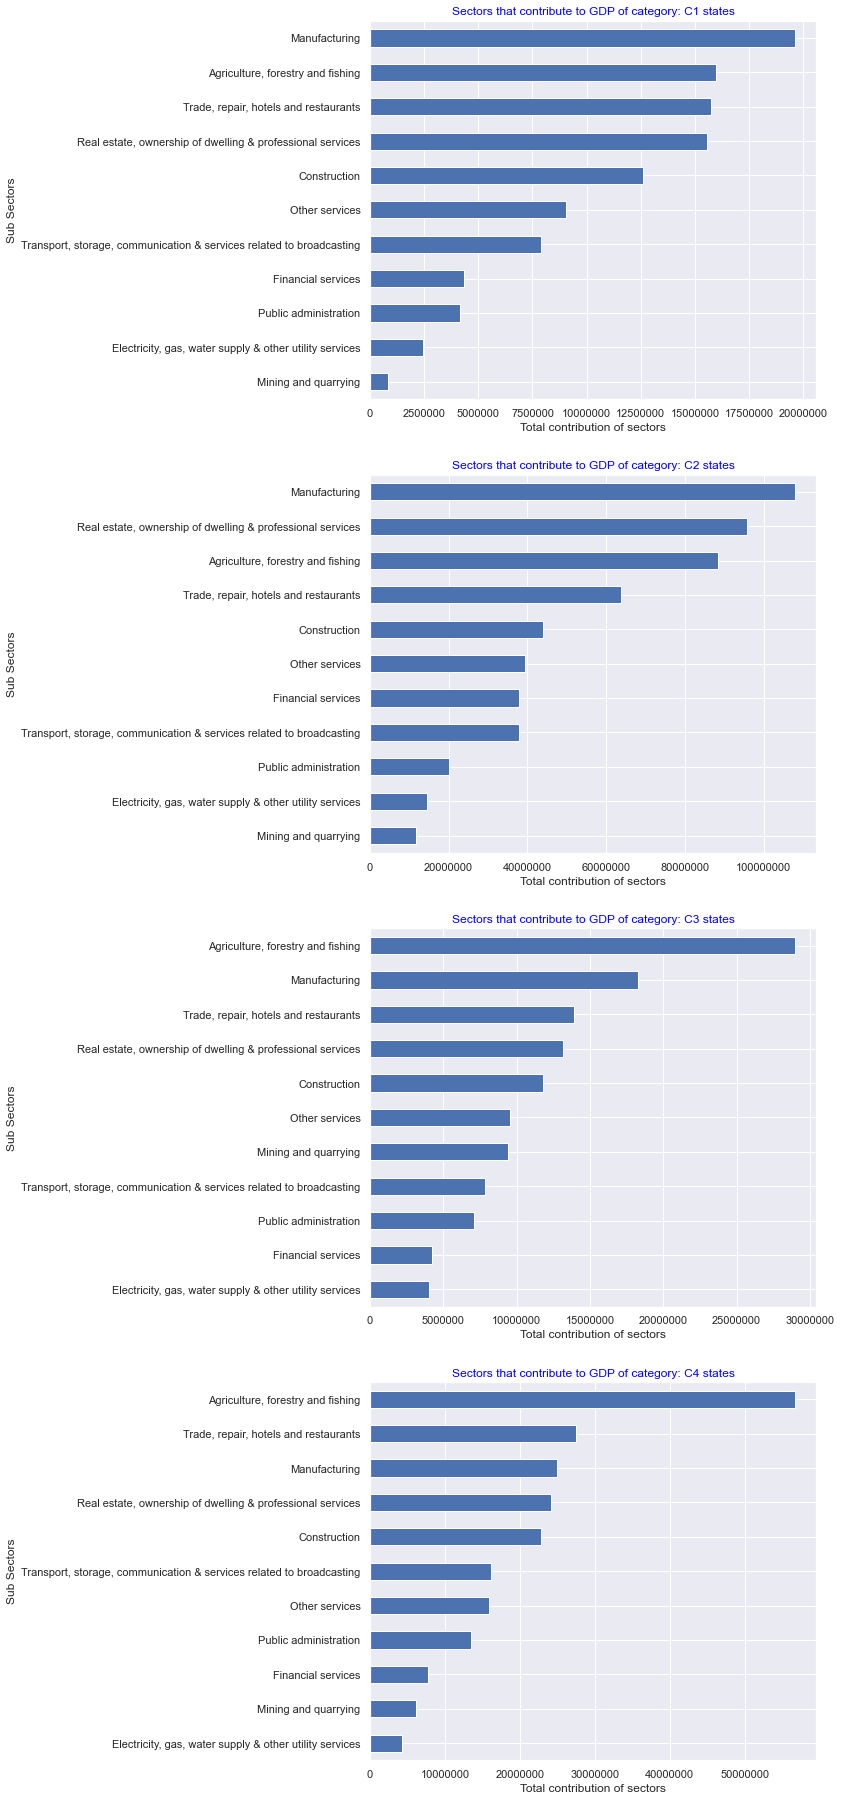

In [94]:
#create category list
category_list = ['C1','C2','C3','C4']

#Call the function to subplot Cetegorywise heatmap of various states
plot_subsector_performance(state_category_df,category_list)

In [95]:
dropout_df = pd.read_csv('./datasets/rop-Out_Rate_from_2012-13_to_2014-15.csv')
dropout_df.head()

,Sl. No.,Level of Education - State,Primary - 2012-2013,Primary - 2014-2015,Primary - 2014-2015.1,Upper Primary - 2012-2013,Upper Primary - 2013-2014,Upper Primary - 2014-2015,Secondary - 2012-2013,Secondary - 2013-2014,Secondary - 2014-2015,Senior Secondary - 2012-2013,Senior Secondary - 2013-2014,Senior Secondary - 2014-2015
0,1,A & N Islands,0.68,1.21,0.51,1.23,0.51,1.69,5.56,7.20,9.87,14.14,15.87,16.93
1,2,Andhra Pradesh,3.18,4.35,6.72,3.36,3.78,5.20,12.72,12.65,15.71,0.35,11.79,NaN
2,3,Arunachal Pradesh,15.16,10.89,10.82,7.47,5.59,6.71,12.93,14.49,17.11,5.11,17.07,18.42
3,4,Assam,6.24,7.44,15.36,7.20,7.05,10.51,26.77,30.43,27.06,4.69,7.24,NaN
4,5,Bihar,NaN,2.09,NaN,NaN,2.98,4.08,30.14,25.33,25.90,NaN,NaN,NaN


In [96]:
pd.DataFrame([[dropout_df.shape],
            [dropout_df.isnull().sum().sum()],
             [dropout_df.duplicated().sum()]],
            columns = ['Dropout Rate Data Set'],
            index = ['Shape', 'Missingness', 'Duplicates'])

,Dropout Rate Data Set
Shape,"(37, 14)"
Missingness,65
Duplicates,0


In [97]:

dropout_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sl. No.                       37 non-null     object 
 1   Level of Education - State    37 non-null     object 
 2   Primary - 2012-2013           29 non-null     float64
 3   Primary - 2014-2015           33 non-null     float64
 4   Primary - 2014-2015.1         31 non-null     float64
 5   Upper Primary - 2012-2013     31 non-null     float64
 6   Upper Primary - 2013-2014     35 non-null     float64
 7   Upper Primary - 2014-2015     35 non-null     float64
 8   Secondary - 2012-2013         34 non-null     float64
 9   Secondary - 2013-2014         36 non-null     float64
 10  Secondary - 2014-2015         36 non-null     float64
 11  Senior Secondary - 2012-2013  24 non-null     float64
 12  Senior Secondary - 2013-2014  27 non-null     float64
 13  Senior 

In [98]:
dropout_df['Level of Education - State'].value_counts

<bound method IndexOpsMixin.value_counts of 0            A & N Islands
1           Andhra Pradesh
2        Arunachal Pradesh
3                    Assam
4                    Bihar
5               Chandigarh
6              Chhatisgarh
7     Dadra & Nagar Haveli
8              Daman & Diu
9                    Delhi
10                     Goa
11                 Gujarat
12                 Haryana
13        Himachal Pradesh
14       Jammu and Kashmir
15               Jharkhand
16               Karnataka
17                  Kerala
18             Lakshadweep
19          Madhya Pradesh
20             Maharashtra
21                 Manipur
22               Meghalaya
23                 Mizoram
24                Nagaland
25                  Odisha
26              Puducherry
27                  Punjab
28               Rajasthan
29                  Sikkim
30              Tamil Nadu
31               Telangana
32                 Tripura
33           Uttar Pradesh
34              Uttrakhand
35         

In [99]:
print('no. of rows: {0} and columns: {1} before dropping Union Territories'.
      format(dropout_df.shape[0],dropout_df.shape[1]))
dropout_df.drop(dropout_df.loc[dropout_df[
     'Level of Education - State'].isin(['A & N Islands','Chandigarh','Dadra & Nagar Haveli',
                                        'Daman & Diu','Delhi','Lakshadweep','Puducherry'])].index,inplace=True)
print('no. of rows: {0} and columns: {1} after dropping Union Territories'.
      format(dropout_df.shape[0],dropout_df.shape[1]))

no. of rows: 37 and columns: 14 before dropping Union Territories
no. of rows: 30 and columns: 14 after dropping Union Territories


In [100]:

print('no. of rows: {0} and columns: {1} before dropping "West Bengal" State'.
      format(dropout_df.shape[0],dropout_df.shape[1]))
dropout_df.drop(dropout_df.loc[dropout_df[
     'Level of Education - State'].isin(['West Bengal'])].index,inplace=True)
print('no. of rows: {0} and columns: {1} after dropping "West Bengal" State'.
      format(dropout_df.shape[0],dropout_df.shape[1]))

no. of rows: 30 and columns: 14 before dropping "West Bengal" State
no. of rows: 29 and columns: 14 after dropping "West Bengal" State


In [101]:
## dropping unwanted columns
print('no. of rows: {0} and columns: {1} before dropping unwanted columns'.
      format(dropout_df.shape[0],dropout_df.shape[1]))
dropout_df = dropout_df[['Level of Education - State','Primary - 2014-2015.1','Upper Primary - 2014-2015',
                       'Secondary - 2014-2015']]
print('no. of rows: {0} and columns: {1} after dropping unwanted columns'.
      format(dropout_df.shape[0],dropout_df.shape[1]))

no. of rows: 29 and columns: 14 before dropping unwanted columns
no. of rows: 29 and columns: 4 after dropping unwanted columns


In [102]:

## rename column Primary 2014-2015.1 to Primary 2014-2015
dropout_df.rename(columns={'Primary - 2014-2015.1':'Primary - 2014-2015'},inplace=True)
## also rename column Level of Education - State to State
dropout_df.rename(columns={'Level of Education - State':'State'},inplace=True)
dropout_df

,State,Primary - 2014-2015,Upper Primary - 2014-2015,Secondary - 2014-2015
1,Andhra Pradesh,6.72,5.20,15.71
2,Arunachal Pradesh,10.82,6.71,17.11
3,Assam,15.36,10.51,27.06
4,Bihar,NaN,4.08,25.90
6,Chhatisgarh,2.91,5.85,21.26
10,Goa,0.73,0.07,11.15
11,Gujarat,0.89,6.41,25.04
12,Haryana,5.61,5.81,15.89
13,Himachal Pradesh,0.64,0.87,6.07
14,Jammu and Kashmir,6.79,5.44,17.28


In [103]:
state_category_df

Item,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,Per Capita GSDP (Rs.),Primary_Perc,Secondary_Perc,Tertiary_Perc,Taxes_Perc,Subsidies_Perc,AllSectors_Perc,Percentile_Rank,Percentile_Corr,Category
0,Andhra_Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,104977,30.97,19.92,41.85,10.47,3.21,92.74,0.79,-0.12,C2
1,Arunachal_Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,112718,42.77,17.15,37.70,4.18,1.81,97.62,0.11,-0.12,C2
2,Assam,3855548,1471149,5326697,2002936,296587,1733568,4033091,2987155,1194568,...,60621,26.89,20.36,46.98,8.71,2.94,94.23,0.43,-0.12,C4
3,Bihar,7951890,68107,8019997,2189965,345168,3449763,5984896,7448373,3147173,...,33954,21.45,16.01,59.32,8.59,5.37,96.78,0.61,-0.12,C4
5,Chattisgarh,3948847,2451970,6400817,4370593,1198438,2669855,8238886,1535571,871770,...,86860,27.24,35.06,32.30,11.07,5.67,94.60,0.50,-0.12,C3
7,Goa,308507,3622,312129,1177608,204110,165819,1547536,380927,189656,...,271793,7.68,38.09,42.78,12.98,1.52,88.55,0.29,-0.12,C1
8,Gujarat,1.377e+07,2.11722e+06,1.58872e+07,2.40875e+07,3.40998e+06,5.52602e+06,3.30235e+07,1.01787e+07,4.55591e+06,...,141263,17.75,36.90,33.76,13.80,2.21,88.41,0.86,-0.12,C2
9,Haryana,8.01524e+06,25186,8.04042e+06,7.75692e+06,1.10192e+06,3.70257e+06,1.25614e+07,4.98632e+06,2.56062e+06,...,164077,18.38,28.71,43.95,11.40,2.44,91.04,0.64,-0.12,C1
10,Himachal_Pradesh,1514981,33385,1548366,2543637,767268,808256,4119162,615496,552234,...,147330,14.84,39.47,39.60,8.58,2.48,93.91,0.36,-0.12,C2
11,Jammu_Kashmir,1586705,33621,1620326,893207,597421,785503,2276132,889931,712552,...,75840,16.14,22.67,55.91,7.61,2.33,94.72,0.32,-0.12,C3


In [104]:
state_category_states =  list(state_category_df['State'])
dropout_states = list(dropout_df['State'])
state_intersection = set(state_category_states)-set(dropout_states)
state_intersection

{'Andhra_Pradesh',
 'Arunachal_Pradesh',
 'Chattisgarh',
 'Himachal_Pradesh',
 'Jammu_Kashmir',
 'Jharkand',
 'Madhya_Pradesh',
 'Tamil_Nadu',
 'Telenghana',
 'Uttar_Pradesh',
 'Uttarakhand'}

In [105]:
dropout_intersection = set(dropout_states)-set(state_category_states)
dropout_intersection

{'All India',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Chhatisgarh',
 'Himachal Pradesh',
 'Jammu and Kashmir',
 'Jharkhand',
 'Madhya Pradesh',
 'Tamil Nadu',
 'Telangana',
 'Uttar Pradesh',
 'Uttrakhand'}

In [106]:
dropout_intersection.remove('All India')
dropout_intersection

{'Andhra Pradesh',
 'Arunachal Pradesh',
 'Chhatisgarh',
 'Himachal Pradesh',
 'Jammu and Kashmir',
 'Jharkhand',
 'Madhya Pradesh',
 'Tamil Nadu',
 'Telangana',
 'Uttar Pradesh',
 'Uttrakhand'}

In [108]:
state_intersection = list(state_intersection)
for i,dropout_state in enumerate(dropout_intersection):
#     print(i, dropout_state)
    dropout_df.loc[dropout_df.loc[dropout_df['State']==dropout_state].index[0],'State']=state_intersection[i]
dropout_df

,State,Primary - 2014-2015,Upper Primary - 2014-2015,Secondary - 2014-2015
1,Jharkand,6.72,5.20,15.71
2,Uttar_Pradesh,10.82,6.71,17.11
3,Assam,15.36,10.51,27.06
4,Bihar,NaN,4.08,25.90
6,Chattisgarh,2.91,5.85,21.26
10,Goa,0.73,0.07,11.15
11,Gujarat,0.89,6.41,25.04
12,Haryana,5.61,5.81,15.89
13,Arunachal_Pradesh,0.64,0.87,6.07
14,Uttarakhand,6.79,5.44,17.28


In [109]:
state_category_states =  list(state_category_df['State'])
dropout_states = list(dropout_df['State'])
state_intersection = set(state_category_states)-set(dropout_states)
print(state_intersection)
dropout_intersection = set(dropout_states)-set(state_category_states)
print(dropout_intersection)

set()
{'All India'}


In [111]:
print('shape of state category df before merge: {0}'.format(state_category_df.shape))
print('shape of dropout df before merge: {0}'.format(dropout_df.shape))
state_dropout_df = pd.merge(state_category_df,dropout_df,on='State',how='left')
print('shape of new df after merge: {0}'.format(state_dropout_df.shape))
state_dropout_df

shape of state category df before merge: (28, 30)
shape of dropout df before merge: (29, 4)
shape of new df after merge: (28, 33)


,State,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",...,Tertiary_Perc,Taxes_Perc,Subsidies_Perc,AllSectors_Perc,Percentile_Rank,Percentile_Corr,Category,Primary - 2014-2015,Upper Primary - 2014-2015,Secondary - 2014-2015
0,Andhra_Pradesh,14819416,1484300,16303716,4672266,1151729,4664889,10488884,4233400,5076984,...,41.85,10.47,3.21,92.74,0.79,-0.12,C2,8.58,2.70,10.22
1,Arunachal_Pradesh,686117,30842,716959,26120,113527,147842,287489,60421,35203,...,37.70,4.18,1.81,97.62,0.11,-0.12,C2,0.64,0.87,6.07
2,Assam,3855548,1471149,5326697,2002936,296587,1733568,4033091,2987155,1194568,...,46.98,8.71,2.94,94.23,0.43,-0.12,C4,15.36,10.51,27.06
3,Bihar,7951890,68107,8019997,2189965,345168,3449763,5984896,7448373,3147173,...,59.32,8.59,5.37,96.78,0.61,-0.12,C4,NaN,4.08,25.90
4,Chattisgarh,3948847,2451970,6400817,4370593,1198438,2669855,8238886,1535571,871770,...,32.30,11.07,5.67,94.60,0.50,-0.12,C3,2.91,5.85,21.26
5,Goa,308507,3622,312129,1177608,204110,165819,1547536,380927,189656,...,42.78,12.98,1.52,88.55,0.29,-0.12,C1,0.73,0.07,11.15
6,Gujarat,1.377e+07,2.11722e+06,1.58872e+07,2.40875e+07,3.40998e+06,5.52602e+06,3.30235e+07,1.01787e+07,4.55591e+06,...,33.76,13.80,2.21,88.41,0.86,-0.12,C2,0.89,6.41,25.04
7,Haryana,8.01524e+06,25186,8.04042e+06,7.75692e+06,1.10192e+06,3.70257e+06,1.25614e+07,4.98632e+06,2.56062e+06,...,43.95,11.40,2.44,91.04,0.64,-0.12,C1,5.61,5.81,15.89
8,Himachal_Pradesh,1514981,33385,1548366,2543637,767268,808256,4119162,615496,552234,...,39.60,8.58,2.48,93.91,0.36,-0.12,C2,NaN,NaN,8.10
9,Jammu_Kashmir,1586705,33621,1620326,893207,597421,785503,2276132,889931,712552,...,55.91,7.61,2.33,94.72,0.32,-0.12,C3,6.59,9.20,24.77


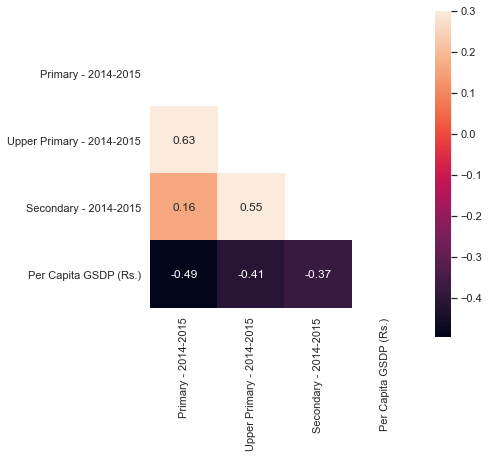

In [112]:
gdp_droput_df = state_dropout_df.copy()
# drop unnecessary columns from dataframe
gdp_droput_df = gdp_droput_df[['Primary - 2014-2015',
                              'Upper Primary - 2014-2015','Secondary - 2014-2015','Per Capita GSDP (Rs.)']]
numeric_cols = [col for col in gdp_droput_df]
gdp_droput_df[numeric_cols] = gdp_droput_df[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)
#states_cat_df.info()

plt.figure(figsize=(6,6))
mask = np.zeros_like(gdp_droput_df.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
      sns.heatmap(gdp_droput_df.corr(),mask=mask,vmax=.3, square=True, annot=True,
                 );#cmap='RdYlGn');

In [113]:
def sector_dropout_heatmap(sector_droput_df,education_levels):
    sns.set(font_scale=1)
    nrows = int(np.ceil(len(education_levels))) # Makes sure you have enough rows
    #tweak figsize scaler if graphs don't fit well
    fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(5,5*len(education_levels)), sharex=False, sharey=False)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    
    for i, edu_level in enumerate(education_levels):
        plt.subplots_adjust(hspace = 1.2)
        # drop unnecessary columns from dataframe
        subset_df = sector_droput_df.copy()
        subset_df = subset_df[['Primary_Perc','Secondary_Perc','Tertiary_Perc',edu_level]]
        numeric_cols = [col for col in subset_df]
        subset_df[numeric_cols] = subset_df[numeric_cols].apply(
            pd.to_numeric, errors='coerce', axis=1)

        mask = np.zeros_like(subset_df.corr())
        mask[np.triu_indices_from(mask)] = True
        with sns.axes_style("white"):
              sns.heatmap(round(subset_df.corr(),2),mask=mask,vmax=.3, square=True, annot=True,
                         ax=ax[i]);#cmap='RdYlGn');
        ax[i].set_title("Correlation of {0} dropout rate with Sectors".format(edu_level),color='blue')

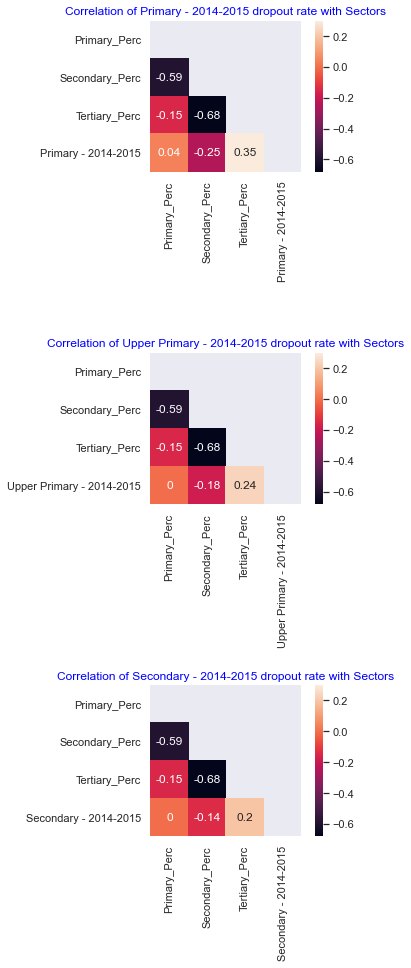

In [114]:
education_levels = ['Primary - 2014-2015','Upper Primary - 2014-2015','Secondary - 2014-2015']
sector_dropout_heatmap(state_dropout_df,education_levels)

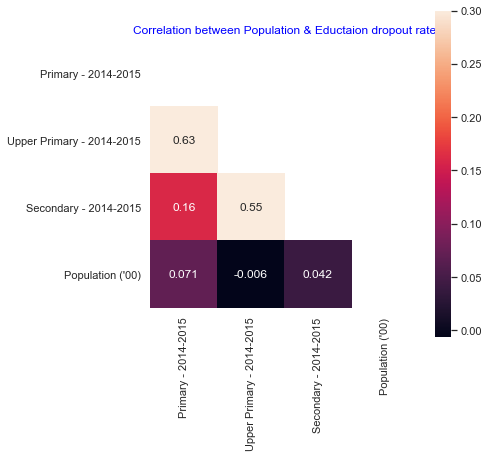

In [115]:
gdp_droput_df = state_dropout_df.copy()
# drop unnecessary columns from dataframe
gdp_droput_df = gdp_droput_df[['Primary - 2014-2015',
                              'Upper Primary - 2014-2015','Secondary - 2014-2015',"Population ('00)",]]
numeric_cols = [col for col in gdp_droput_df]
gdp_droput_df[numeric_cols] = gdp_droput_df[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)
#states_cat_df.info()

plt.figure(figsize=(6,6))
mask = np.zeros_like(gdp_droput_df.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
      sns.heatmap(gdp_droput_df.corr(),mask=mask,vmax=.3, square=True, annot=True,
                 );#cmap='RdYlGn');
plt.title("Correlation between Population & Eductaion dropout rate",color='blue');